# Under-Representation Bias (w/ Synthetic Data)

This notebook recreates the finding that Equalized Odds constrained model can recover from under-representation bias.

### Setup

Please run the code block below to install the necessary packages (if needed).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.base import clone

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from collections import Counter

import fairlearn
from fairlearn.metrics import *
from fairlearn.reductions import *
from fairlearn.postprocessing import *
import aif360

import copy, random

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Synthetic Dataset Generation

## Parameters (User Input)

In [2]:
'''

r is the proportion of training examples in the minority group, 

which means 1-r is proportion of examples in the majority group

eta is the probability of flipping the label

n is the number of training examples

beta is the probability of keeping a positively labeled example
from the minority class

NOTE: results can be replicated if and only if the following condition holds:

(1-r)(1-2*eta) + r((1-eta)*beta - eta) > 0

'''
def get_params(r = 1/3, eta = 1/4, n = 2000, beta = 0.5):
    return r, eta, n, beta

r, eta, n, beta = get_params(r = 1/3, eta = 0, n = 30000)

In [3]:
# check if above constraint holds
def check_constraints(r, eta, beta):
    first = (1-r)*(1-2*eta)
    second = r * ((1-eta)*beta - eta)
    res = first + second
    print("constraint: ", res)
    print("yes!", r, eta, beta) if res > 0 else print("no", r, eta, beta)
    
bias_amts = np.divide(list(range(10, -1, -1)),10)

for beta in bias_amts:
    check_constraints(r=0.2, eta=0.4, beta=beta)

constraint:  0.19999999999999996
yes! 0.2 0.4 1.0
constraint:  0.18799999999999997
yes! 0.2 0.4 0.9
constraint:  0.17599999999999996
yes! 0.2 0.4 0.8
constraint:  0.16399999999999998
yes! 0.2 0.4 0.7
constraint:  0.15199999999999997
yes! 0.2 0.4 0.6
constraint:  0.13999999999999996
yes! 0.2 0.4 0.5
constraint:  0.12799999999999997
yes! 0.2 0.4 0.4
constraint:  0.11599999999999996
yes! 0.2 0.4 0.3
constraint:  0.10399999999999997
yes! 0.2 0.4 0.2
constraint:  0.09199999999999997
yes! 0.2 0.4 0.1
constraint:  0.07999999999999996
yes! 0.2 0.4 0.0


## True Label Generation

In [4]:
# create minority and majority groups
def get_cat_features(n, r):
    num_minority = int(r * n)
    num_majority = n - num_minority
    
    minority = np.zeros((num_minority, 1))
    majority = np.ones((num_majority, 1))
    
    cat_features = np.vstack((minority, majority))
    #np.random.shuffle(cat_features) # this is what causes us to not recover coeffs
    
    return cat_features

In [5]:
# return labels from Bayes Optimal Classifier
def get_bayes_optimal_labels(features, effect_param, threshold = 0.5):
    outcome_continuous = 1/(1+np.exp(-np.matmul(features, effect_param)))
    #return outcome_continuous, np.random.binomial(1,outcome_continuous) # bernoulli to simulate LR's probabilistic nature
    return outcome_continuous, np.where(outcome_continuous < threshold, 0, 1)

# flip labels with probability eta
# def flip_labels(df_synthetic, eta):
#     labels = df_synthetic['outcome']
#     #print('Before:', df_synthetic['outcome'].value_counts())
#     num_flipped = 0
#     for i in range(len(labels)):
#         if random.uniform(0,1) <= eta:
#             labels[i] = 1 if labels[i] == 0 else 0
#             num_flipped += 1
#     df_synthetic['outcome'] = labels
#     #print('After:', df_synthetic['outcome'].value_counts())
#     #print('Num Flipped: ', num_flipped, "\tRate: ", num_flipped / len(df_synthetic))
#     return df_synthetic

def flip_labels(df_synthetic, eta):
    labels = list(df_synthetic['outcome'].values)
    #print('Before:', df_synthetic['outcome'].value_counts())
    num_flipped = 0
    for i in range(len(labels)):
        if random.uniform(0,1) <= eta:
            labels[i] = 1 if labels[i] == 0 else 0
            num_flipped += 1
    df_synthetic['outcome_flipped'] = labels
    df_synthetic['outcome'] = labels
    #print('After:', df_synthetic['outcome'].value_counts())
    #print('Num Flipped: ', num_flipped, "\tRate: ", num_flipped / len(df_synthetic))
    return df_synthetic

# use this function to inject eta_maj into both majority and negatively labeled minority samples
def flip_labels2(df_majority, eta_maj, df_minority, eta_min, inter = True):
    labels_maj = list(df_majority['outcome'].values)
    labels_min = list(df_minority['outcome'].values)
    
    num_flipped_maj = 0
    for i in range(len(labels_maj)):
        if random.uniform(0,1) <= eta_maj:
            labels_maj[i] = 1 if labels_maj[i] == 0 else 0
            num_flipped_maj += 1
    df_majority['outcome_flipped'] = labels_maj
    print('Num Flipped Maj: ', num_flipped_maj, "\tRate: ", num_flipped_maj / len(df_majority))
    if not inter: df_minority['outcome_flipped'] = labels_min
    
    if inter:
    
        #df_majority['diff'] = abs(df_majority['outcome'] - df_majority['outcome_flipped'])
        #print(df_minority.groupby('outcome')['diff'].value_counts(normalize=True))

        neg = len(df_minority[df_minority['outcome'] == 0])

        num_flipped_min = 0
        for i in range(len(labels_min)):
            if random.uniform(0,1) <= eta_maj and labels_min[i] == 0:
                labels_min[i] = 1
                num_flipped_min += 1

        df_minority['outcome_flipped'] = labels_min
        #df_minority['diff'] = abs(df_minority['outcome'] - df_minority['outcome_flipped'])
        #print("minority", df_minority.groupby('outcome')['diff'].value_counts(normalize=True))

        print('Num Flipped Min Neg: ', num_flipped_min, "\tRate: ", num_flipped_min / neg)

    df_concat = pd.concat([df_majority, df_minority])
    #print(df_majority.shape, df_minority.shape)
    #df_concat = pd.DataFrame(np.vstack([df_majority, df_minority]))
    #df_concat.columns = ['num1','num2','num3','cat','outcome','outcome_flipped', 'diff']
    
    #print("concat", df_concat.groupby(['cat','outcome'])['diff'].value_counts(normalize=True))
    return df_concat.sample(frac=1, random_state = 42) # permute data

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'
'''

create synthetic data with:
    3 numerical features (Gaussian), 1 categorical (sensitive attribute) 
    logistic outcome model s.t. outcome = Indicator[logit(effect_param*features) >= 0.5]
    
create minority/majority groups according to r param

simulate Bayes Optimal Classifiers for minority and majority

flip labels according to eta param

ensure equal base rates (proportion of positive examples) across both groups

is_exploration is for group-dependent label noise

'''

def true_label_generation(r, eta, n, maj_means = [0,0,0], is_exploration = False, inter = True):

    ''' 
    delete this variable to allow user to control percentage of positively labeled examples
    eg: let outcome_continuous >= 0.2 implies 80% positively labeled samples
    '''
    # causal effect params
    maj_params = [-0.7, 0.5, 1.5]
    effect_param_min = [0.5, -0.2, 0.1]
    #effect_param_maj = [i + np.random.uniform(low = -1, high = 1) for i in maj_params]
    effect_param_maj = maj_params
    
    num_min = int(n*r)
    num_maj = n - num_min

    # required: len(cat_probabilities) = n_cat_features
    n_cat_features = 2
    cat_probabilities = [0.5, 0.5] 

    # numerical feature params
    means = [0, 0, 0]
    cov_matrix = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

    # features
    cat_features = get_cat_features(r=r, n=n)
    
    num_features_min = np.random.multivariate_normal(means, cov_matrix, num_min)
    #num_features_min = np.random.normal(0, 1, num_min)
    num_features_maj = np.random.multivariate_normal(maj_means, cov_matrix, num_maj)
    # num_features_maj = np.array([i + np.random.uniform(low = -15, high = 10) for i in num_features_maj])
    #num_features_min = np.random.normal(0, 1, num_min)

    num_features = np.concatenate((num_features_min, num_features_maj))

    # outcomes
    outcome_continuous_min, outcome_binary_min = get_bayes_optimal_labels(features=num_features_min, effect_param=effect_param_min, threshold = 0.5)
    #outcome_binary_min = np.where(np.matmul(num_features_min, effect_param_min) > 0.5, 1, 0)
    outcome_continuous_maj, outcome_binary_maj = get_bayes_optimal_labels(features=num_features_maj, effect_param=effect_param_maj, threshold = 0.5)
    #outcome_binary_maj = np.where(np.matmul(num_features_maj, effect_param_maj) > 0.5, 1, 0)
    
    outcome = np.hstack((outcome_binary_min,outcome_binary_maj)).reshape(n,1)
    outcome_continuous = np.hstack((outcome_continuous_min,outcome_continuous_maj)).reshape(n,1)
    temp_data = np.hstack((num_features,cat_features, outcome, outcome_continuous))
    #print(outcome_continuous)
    #print(np.where(outcome_continuous < 0.5, 0, 1))
    np.random.shuffle(temp_data) # randomly shuffle the data
    
    df_synthetic = pd.DataFrame(temp_data)
    df_synthetic.columns = ['num1','num2','num3','cat','outcome','outcome_cont']
    
    outcome_continuous = df_synthetic.outcome_cont
    df_synthetic = df_synthetic[['num1','num2','num3','cat','outcome']]
    
    df_majority = df_synthetic[df_synthetic['cat'] == 1]
    df_minority = df_synthetic[df_synthetic['cat'] == 0]
    
    #print('% Positive Majority: ', df_majority['outcome'].value_counts()[1] / len(df_majority))
    #print('\n% Positive Minority: ', df_minority['outcome'].value_counts()[1] / len(df_minority))
    print('Diff: ', df_majority['outcome'].value_counts()[1] / len(df_majority)- df_minority['outcome'].value_counts()[1] / len(df_minority))
    #print('\nTotal: ', df_majority['outcome'].value_counts())
    
    if inter:
        if not is_exploration: 
            df_synthetic = flip_labels(df_synthetic, eta)
        else:
            df_synthetic = flip_labels2(df_majority, 0.4, df_minority, 0) # group dependent label noise
    else:
        df_synthetic = flip_labels2(df_majority, 0.4, df_minority, 0, inter = False) # group dependent label noise

    return outcome_continuous, df_synthetic 

outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n, maj_means = [0,0,0], is_exploration=True, inter=False)

Diff:  -0.004799999999999971
Num Flipped Maj:  16070 	Rate:  0.40175


In [7]:
# df_synthetic['diff'] = abs(df_synthetic['outcome'] - df_synthetic['outcome_flipped'])
# df_synthetic.groupby(['cat','outcome'])['diff'].value_counts(normalize=True)

def check_groups(df):
    df = df.copy()
    df['diff'] = abs(df['outcome'] - df['outcome_flipped'])
    print(df.groupby(['cat','outcome'])['diff'].value_counts(normalize=True))

check_groups(df_synthetic)

cat  outcome  diff
0.0  0.0      0.0     1.000000
     1.0      0.0     1.000000
1.0  0.0      0.0     0.597786
              1.0     0.402214
     1.0      0.0     0.598717
              1.0     0.401283
Name: diff, dtype: float64


# Preparation

### Data Preprocessing

In [8]:
# split into train and test
df_train = df_synthetic.loc[range(0,int(n/2)), :]
# if original dataset has odd number of samples, remove 1 sample to be even
if (n % 2 == 1):
    df_test = df_synthetic.loc[range(int(n/2)+1, n), :]
else:
    df_test = df_synthetic.loc[range(int(n/2), n), :]

df_fidel = df_synthetic.loc[range(n, len(df_synthetic)),:]
outcome_cts = outcome_continuous[n:len(df_synthetic)]
    
df_test_maj = df_test[df_test['cat'] == 1]
df_test_min = df_test[df_test['cat'] == 0]

# format data
X_true = df_test.iloc[:, :-2].values
y_true = df_test.iloc[:, -1].values

X_true_maj = df_test_maj.iloc[:, :-2].values
y_true_maj = df_test_maj.iloc[:, -1].values
X_true_min = df_test_min.iloc[:, :-2].values
y_true_min = df_test_min.iloc[:, -1].values

sens_attrs_true = [df_test['cat']]

# Bias Injection

In [9]:
# measurement bias
def inject_noise_num(df, feature, eps = 1):
    for i in range(len(df[feature])):
        df[feature].iloc[i] += np.random.normal(0, 1) * eps # standard normal

    return df

In [10]:
from numpy import percentile
def under_sample(df_minority_positive, beta):
    X_min = df_minority_positive.iloc[:, :].values
    
    # keep each example with probability beta
    num_dropped = 0
    for i in range(len(X_min)):
        if random.uniform(0,1) > beta:
            X_min = np.delete(X_min, 0, axis=0)
            num_dropped += 1
    #print("Total Deleted: ", num_dropped, "\t % Deleted: ", num_dropped / len(df_minority_positive))
    df_minority_positive = pd.DataFrame(pd.DataFrame(X_min))
    df_minority_positive.columns = ['num1','num2','num3','cat','outcome', 'outcome_flipped']
    return df_minority_positive


def get_biased_data(df_train, beta):
    df_majority = df_train[df_train['cat'] == 1]
    df_minority = df_train[df_train['cat'] == 0]
    
    # unfavored group with negative label
    df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

    # unfavored group with positive label (preferred)
    df_minority_positive = df_minority[df_minority['outcome'] == 1.0]
    
    # data frame without positively labeled examples from minority class
    df_total = pd.concat([df_majority, df_minority_negative])
    
    # under-sampling process
    df_undersampled = under_sample(df_minority_positive, beta)

    # combine undersampled and original favored class to create dataset
    df_concat = pd.concat([df_total,df_undersampled])
    
    return df_concat.sample(frac=1) # permute data


'''

# representation bias, under-sampling entire minority
def get_biased_data(df_train, beta):
    df_majority = df_train[df_train['cat'] == 1]
    df_minority = df_train[df_train['cat'] == 0]
    
    # under-sampling process
    df_undersampled = under_sample(df_minority, beta)

    # combine undersampled and original favored class to create dataset
    df_concat = pd.concat([df_majority,df_undersampled])
    
    return df_concat.sample(frac=1) # permute data
'''

def get_summary_num(df, feature):
    res = dict()
    res['attribute'] = feature

    data_min, data_max = df[feature].min(), df[feature].max()
    res['min'] = data_min
    res['max'] = data_max

    quartiles = percentile(df[feature], [25,50,75])
    res['1st Quartile'] = quartiles[0]
    res['2nd Quartile'] = quartiles[1]
    res['3rd Quartile'] = quartiles[2]

    return res

#print(len(df_train[(df_train['cat'] == 0) & (df_train['outcome'] == 1)]))
print(get_summary_num(df_train, 'num1'))
df_concat = get_biased_data(df_train, 0.5)
print(get_summary_num(df_concat, 'num1'))
#print(len(df_concat[(df_concat['cat'] == 0) & (df_concat['outcome'] == 1)]))

# for fairness measures later
df_sens = df_concat['cat']

# format data
X_bias = df_concat.iloc[:, :-2].values
y_bias = df_concat.iloc[:, -1].values

{'attribute': 'num1', 'min': -4.402114371237914, 'max': 3.7684471201461927, '1st Quartile': -0.6724047425981724, '2nd Quartile': -0.00014691158212111068, '3rd Quartile': 0.6614565259816217}
{'attribute': 'num1', 'min': -4.402114371237914, 'max': 3.7684471201461927, '1st Quartile': -0.7343612341393261, '2nd Quartile': -0.07489331687491849, '3rd Quartile': 0.5886896612953523}


In [11]:
''' Nil-Jana's Suggestions '''

def transform(df, is_test = False, is_train = False):

    sens_feat = df['cat'].values
    outcome = df['outcome'].values
    outcome_flipped = df['outcome_flipped'].values
    num_feats = df.iloc[:, :-3].values

    trans_feats = [] # x1a - x3a
    other_feats = [] # x1(1-a) - x3(1-a)
    # -2 for sensitive feature and label
    for i in range(len(df.columns) - 3):
        num_feat = df.iloc[:, i].values
        num_feat_transf = np.multiply(num_feat, sens_feat)
        trans_feats += [num_feat_transf.reshape((len(df),))]
        
        num_feat_other = df.iloc[:, i].values
        num_feat_other_transf = np.multiply(num_feat, (1-sens_feat))
        other_feats += [num_feat_other_transf.reshape((len(df),))]


    temp_data = np.hstack((other_feats[0].reshape((len(df),1)), other_feats[1].reshape((len(df),1)), other_feats[2].reshape((len(df),1)),
                           trans_feats[0].reshape((len(df),1)), trans_feats[1].reshape((len(df),1)), trans_feats[2].reshape((len(df),1)),
                           outcome.reshape((len(df),1)), outcome_flipped.reshape((len(df),1))))

    df_transf = pd.DataFrame(temp_data)
    df_transf.columns = ['num1*(1-a)','num2*(1-a)','num3*(1-a)', 'num1*a','num2*a','num3*a','outcome', 'outcome_flipped']

    # for fairness measures later
    df_sens = df['cat']
    maj_list = list(df[df['cat'] == 1].index)
    min_list = list(df[df['cat'] == 0].index)
    
    for i in range(len(maj_list)):
        if is_train: maj_list[i] = maj_list[i]
        else: maj_list[i] = maj_list[i] - len(df)
        
    for i in range(len(min_list)):
        if is_train:
            min_list[i] = min_list[i]
        else: min_list[i] = min_list[i] - len(df)

    # format data
    X_bias = df_transf.iloc[:, :-2].values
    y_bias = df_transf.iloc[:, -1].values
    
    if not is_test:
        return X_bias, y_bias, df_sens
    else:
        return df_transf, maj_list, min_list

df_transf, _, _ = transform(df_test, True)

# Evaluation

In [12]:
def under(df, beta):
    X_min = df.iloc[:, :].values
    
    # keep each example with probability beta
    num_dropped = 0
    for i in range(len(X_min)):
        if random.uniform(0,1) > beta:
            X_min = np.delete(X_min, 0, axis=0)
            num_dropped += 1
    print("Total Deleted: ", num_dropped, "\t % Deleted: ", num_dropped / len(df))
    is_empty = (num_dropped / len(df)) == 1.0
    df = pd.DataFrame(pd.DataFrame(X_min))
    df.columns = ['num1','num2','num3','cat','outcome', 'outcome_flipped']
    
    return df, is_empty

In [13]:
def remove_nan(x):
    x = np.array(x)
    means = np.mean(x, axis = 0)
    for i in range(len(means)):
        if np.isnan(means[i]):
            print('nah')
            col_len = len(x[:, i])
            col_sum = 0
            for val in x[:, i]:
                if np.isnan(val): col_len -= 1
                else: col_sum += val
            means[i] = col_sum / col_len
    return means

def remove_nan_std(x):
    x = np.array(x)
    std_devs = np.std(x, axis = 0)
    for i in range(len(std_devs)):
        if np.isnan(std_devs[i]):
            print('wut')
            col_std = []
            for val in x[:, i]:
                if ~np.isnan(val): col_std += [val]
            std_devs[i] = np.std(np.array(col_std))
    return std_devs

In [14]:
def tradeoff_visualization_error(r, n, apply_fairness = True, verbose = False, num_iters = 10):
    
    empty_dict = dict()
    empty_dict['0.9'] = 0
    empty_dict['0.95'] = 0
    
    total_fidel_maj = []
    total_fidel_min = []
    total_fidel = []
    
    total_disp_bias_train = []
    total_disp_bo_train = []
    total_disp_mitigated_train = []
    
    total_disp_bias_test = []
    total_disp_bo_test = []
    total_disp_mitigated_test = []
    
    total_acc_bias_train = []
    total_acc_bo_train = []
    total_acc_mitigated_train = []
    
    total_acc_bias_test = []
    total_acc_bo_test = []
    total_acc_mitigated_test = []
    
    for i in range(num_iters):
    
        # 1 to 0 in increments of 0.1
        bias_amts = np.divide(list(range(10,-1,-1)),10)
        bias_amts[-1] = 0.05
        
        test_maj = []
        test_min = []
        total = []
        
        disp_bias_train = []
        disp_bo_train = []
        disp_mitigated_train = []
        
        disp_bias_test = []
        disp_bo_test = []
        disp_mitigated_test = []
        
        acc_bias_train = []
        acc_bo_train = []
        acc_mitigated_train = []
        
        acc_bias_test = []
        acc_bo_test = []
        acc_mitigated_test = []
        
        count = 0
        outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n, is_exploration=False)
        
        threshold = 0.5
        exact_bo_labels = np.where(outcome_continuous < threshold, 0, 1)
        exact_bo_labels_train = np.array(exact_bo_labels[range(0,n)])
        exact_bo_labels_test = np.array(exact_bo_labels[range(n,len(df_synthetic))])
        
        # split into train and test
        df_train = df_synthetic.loc[range(0,n), :]
        #check_groups(df_train)
        
        df_train_transf, maj_list, min_list = transform(df_train, True, True)
        
        df_test = df_synthetic.loc[range(n, len(df_synthetic)),:]
        df_maj = df_test[df_test['cat'] == 1]
        df_min = df_test[df_test['cat'] == 0]
        #check_groups(df_test)
        df_test_transf, maj_list, min_list = transform(df_test, True, False)
        
        df_test_maj = df_test_transf.loc[maj_list]
        df_test_min = df_test_transf.loc[min_list]

        # format training data
        X_true = df_train_transf.iloc[:, :-2].values
        y_true = df_train_transf.iloc[:, -1].values
        
        # format test data
        X_test = df_test_transf.iloc[:, :-2].values
        X_test_maj = df_test_maj.iloc[:, :-2].values
        X_test_min = df_test_min.iloc[:, :-2].values
        y_test = df_test_transf.iloc[:, -1].values
        y_test_maj = df_test_maj.iloc[:, -1].values
        y_test_min = df_test_min.iloc[:, -1].values
        
        sens_attr_test = df_test['cat']
        sens_attr_maj = df_maj['cat']
        sens_attr_min = df_min['cat']
        
        for beta in bias_amts:
            
            if i == 0: print("Beta: ", beta, '\n')

            df_train_copy = df_train.copy()

            df_majority = df_train_copy[df_train_copy['cat'] == 1]
            df_minority = df_train_copy[df_train_copy['cat'] == 0]
            
            # NOTE: we can use outcome_flipped in both lines below but
            #.      we set outcome = outcome_flipped in flip_labels

            # unfavored group with negative label
            df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

            # unfavored group with positive label (preferred)
            df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

            # data frame without positively labeled examples from minority class
            df_total = pd.concat([df_majority, df_minority_negative])

            # under-sampling process
            df_undersampled, is_empty = under(df_minority_positive, beta)
            
            if is_empty:
                empty_dict[str(1-beta)] += 1
                print(empty_dict)

            # combine undersampled and original favored class to create dataset
            df_concat = pd.concat([df_total,df_undersampled]).sample(frac=1, random_state = 42)
            #check_groups(df_concat)
            
            # format data
            X_bias_true, y_bias_true, df_sens = transform(df_concat)
            
            # model trained on biased data
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_bias = classifier.fit(X_bias_true, y_bias_true)
            
            acc = accuracy_score(y_test,classifier_bias.predict(X_test))
            #print(f'Biased classifier:')
            #print(f'     Test accuracy = {acc}')
            acc_bias_test += [acc]
            acc_bias_train += [accuracy_score(y_bias_true, classifier_bias.predict(X_bias_true))]
            
            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bias_train += [disparity.gamma(classify).max()]

            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bias_test += [disparity.gamma(classify).max()]
            
            # Learned bayes optimal classifier
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_b = classifier.fit(X_true, y_true)        
            #print('COEF: ', classifier_b.coef_)
            #print('INTERCEPT: ', classifier_b.intercept_)
            #classifier_b = clone(classifier).fit(X_true, y_true)
            acc = accuracy_score(y_test,classifier_b.predict(X_test))
            #print(f'Learned BO classifier:')
            #print(f'     Test accuracy = {acc}')
            acc_bo_test += [acc]
            acc_bo_train += [accuracy_score(y_bias_true, classifier_b.predict(X_bias_true))]
            
            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bo_train += [disparity.gamma(classify).max()]

            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bo_test += [disparity.gamma(classify).max()]
            
            
            # Exact BO optimal classifier
            #print(f'Exact BO classifier:')
            acc = accuracy_score(y_test,exact_bo_labels_test)
            #print(f'     Test accuracy = {acc}')
            acc = accuracy_score(y_true,exact_bo_labels_train)
            #print(f'     Train accuracy = {acc}')

            if apply_fairness:
                if not is_empty:
                    constraint = EqualizedOdds()
                    classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none', fit_intercept = False, max_iter = 200)   

    #                 classifier_mitigated_bias = GridSearch(estimator=classifier,
    #                                                        constraints=constraint,
    #                                                        selection_rule='tradeoff_optimization',
    #                                                        constraint_weight=0.5,
    #                                                        grid_size=10,
    #                                                        grid_limit=2.0,
    #                                                        grid_offset=None,
    #                                                        grid=None,
    #                                                        sample_weight_name='sample_weight')

                    classifier_mitigated_bias = ThresholdOptimizer(estimator=clone(classifier_bias), constraints= 'equalized_odds', predict_method='auto')

                    classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)

                    #acc = accuracy_score(y_test,classifier_mitigated_bias.predict(X_test))
                    acc = accuracy_score(y_test,classifier_mitigated_bias.predict(X_test, sensitive_features=sens_attr_test))
                    #print(f'Mitigated bias classifier:')
                    #print(f'     Test accuracy = {acc}')
                    acc_mitigated_test += [acc]
                    #acc_mitigated_train += [accuracy_score(y_bias_true, classifier_mitigated_bias.predict(X_bias_true))]
                    acc_mitigated_train += [accuracy_score(y_bias_true, classifier_mitigated_bias.predict(X_bias_true, sensitive_features=df_sens))]

                    m = classifier_mitigated_bias
                    def classify(X): return m.predict(X, sensitive_features = df_sens)
                    error = ErrorRate()
                    error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                    disparity = EqualizedOdds()
                    disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                    #print(f'     Train error = {error.gamma(classify)[0]}')
                    #print(f'     Train disparity = {disparity.gamma(classify).max()}')
                    disp_mitigated_train += [disparity.gamma(classify).max()]

                    m = classifier_mitigated_bias
                    def classify(X): return m.predict(X, sensitive_features = sens_attr_test)
                    error = ErrorRate()
                    error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                    disparity = EqualizedOdds()
                    disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                    #print(f'     Test error = {error.gamma(classify)[0]}')
                    #print(f'     Test disparity = {disparity.gamma(classify).max()}')
                    disp_mitigated_test += [disparity.gamma(classify).max()]

                    # Alternative fidelity of intervention model to no intervention model
                    alt_fid_train = accuracy_score(classifier_mitigated_bias.predict(X_bias_true, sensitive_features = df_sens),classifier_bias.predict(X_bias_true))
                    alt_fid_test = accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test),classifier_bias.predict(X_test))
                    #print(f'Alternative fidelity of intervention model to no intervention model: train = {alt_fid_train}, test = {alt_fid_test}')
                else:
                    disp_mitigated_train += [np.nan]
                    disp_mitigated_test += [np.nan]

                    acc_mitigated_train += [np.nan]
                    acc_mitigated_test += [np.nan]

            else:
                classifier_mitigated_bias = clone(classifier_bias)
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true)
                
                disp_mitigated_train += [0]
                disp_mitigated_test += [0]
                
                acc_mitigated_train += [0]
                acc_mitigated_test += [0]
                
                # NOTE: disparities are the same as for classifier_bias

            
            if not is_empty:
                if apply_fairness:
                    # Fidelity in this step
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test),classifier_b.predict(X_test))
                    #print(f'Test set fidelity of learned BO classifier and mitigated_bias_classifier: {fid}')
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test),exact_bo_labels_test)
                    #print(f'Test set fidelity of exact BO classifier and mitigated biased classifier: {fid}')
                else:
                    # Fidelity in this step
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test),classifier_b.predict(X_test))
                    #print(f'Test set fidelity of learned BO classifier and mitigated_bias_classifier: {fid}')
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test),exact_bo_labels_test)
                    #print(f'Test set fidelity of exact BO classifier and mitigated biased classifier: {fid}')
                
            fid = accuracy_score(classifier_bias.predict(X_test),classifier_b.predict(X_test))
            #print(f'Test set fidelity of learned BO classifier and biased classifier: {fid}')
            
            if not is_empty:
                if apply_fairness:
                    # fidelity check
                    test_maj += [accuracy_score(classifier_mitigated_bias.predict(X_test_maj, sensitive_features = sens_attr_maj), classifier_b.predict(X_test_maj))]
                    #print(test_maj)
                    test_min += [accuracy_score(classifier_mitigated_bias.predict(X_test_min, sensitive_features = sens_attr_min), classifier_b.predict(X_test_min))]
                    #print(test_min)
                    total += [accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test), classifier_b.predict(X_test))]
                else:
                    # fidelity check
                    test_maj += [accuracy_score(classifier_mitigated_bias.predict(X_test_maj), classifier_b.predict(X_test_maj))]
                    #print(test_maj)
                    test_min += [accuracy_score(classifier_mitigated_bias.predict(X_test_min), classifier_b.predict(X_test_min))]
                    #print(test_min)
                    total += [accuracy_score(classifier_mitigated_bias.predict(X_test), classifier_b.predict(X_test))]
            else:
                test_maj += [np.nan]
                test_min += [np.nan]
                total += [np.nan]
                
            if verbose:
                #print("Finished Iteration: ", count)
                count +=1
        
        #print(f'Fidelity test maj: {test_maj}')
        #print(f'Fidelity test min: {test_maj}')
        
        total_fidel_maj.append(test_maj)
        total_fidel_min.append(test_min)
        total_fidel.append(total)
        
        total_disp_bias_train.append(disp_bias_train)
        total_disp_bo_train.append(disp_bo_train)
        total_disp_mitigated_train.append(disp_mitigated_train)

        total_disp_bias_test.append(disp_bias_test)
        total_disp_bo_test.append(disp_bo_test)
        total_disp_mitigated_test.append(disp_mitigated_test)
        
        total_acc_bias_train.append(acc_bias_train)
        total_acc_bo_train.append(acc_bo_train)
        total_acc_mitigated_train.append(acc_mitigated_train)

        total_acc_bias_test.append(acc_bias_test)
        total_acc_bo_test.append(acc_bo_test)
        total_acc_mitigated_test.append(acc_mitigated_test)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
                
    if apply_fairness:
    
        mean_fidel_maj = remove_nan(total_fidel_maj)
        mean_fidel_min = remove_nan(total_fidel_min)
        mean_fidel = remove_nan(total_fidel)

        mean_disp_bias_train = remove_nan(total_disp_bias_train)
        mean_disp_bo_train = remove_nan(total_disp_bo_train)
        mean_disp_mitigated_train = remove_nan(total_disp_mitigated_train)

        mean_disp_bias_test = remove_nan(total_disp_bias_test)
        mean_disp_bo_test = remove_nan(total_disp_bo_test)
        mean_disp_mitigated_test = remove_nan(total_disp_mitigated_test)

        y_err_disp_bias_test = remove_nan_std(total_disp_bias_test)
        y_err_disp_bo_test = remove_nan_std(total_disp_bo_test)
        y_err_disp_mitigated_test = remove_nan_std(total_disp_mitigated_test)

        mean_acc_bias_train = remove_nan(total_acc_bias_train)
        mean_acc_bo_train = remove_nan(total_acc_bo_train)
        mean_acc_mitigated_train = remove_nan(total_acc_mitigated_train)

        mean_acc_bias_test = remove_nan(total_acc_bias_test)
        mean_acc_bo_test = remove_nan(total_acc_bo_test)
        mean_acc_mitigated_test = remove_nan(total_acc_mitigated_test)

        y_err_acc_bias_test = remove_nan_std(total_acc_bias_test)
        y_err_acc_bo_test = remove_nan_std(total_acc_bo_test)
        y_err_acc_mitigated_test = remove_nan_std(total_acc_mitigated_test)

        y_err_fidel_maj = remove_nan_std(total_fidel_maj)
        y_err_fidel_min = remove_nan_std(total_fidel_min)
        y_err_fidel = remove_nan_std(total_fidel)
        
    else:
        mean_fidel_maj = np.mean(total_fidel_maj, axis = 0)
        mean_fidel_min = remove_nan(total_fidel_min, axis = 0)
        mean_fidel = remove_nan(total_fidel, axis = 0)

        mean_disp_bias_train = remove_nan(total_disp_bias_train, axis = 0)
        mean_disp_bo_train = remove_nan(total_disp_bo_train, axis = 0)
        mean_disp_mitigated_train = remove_nan(total_disp_mitigated_train, axis = 0)

        mean_disp_bias_test = remove_nan(total_disp_bias_test, axis = 0)
        mean_disp_bo_test = remove_nan(total_disp_bo_test, axis = 0)
        mean_disp_mitigated_test = remove_nan(total_disp_mitigated_test, axis = 0)

        y_err_disp_bias_test = remove_nan_std(total_disp_bias_test, axis = 0)
        y_err_disp_bo_test = remove_nan_std(total_disp_bo_test, axis = 0)
        y_err_disp_mitigated_test = remove_nan_std(total_disp_mitigated_test, axis = 0)

        mean_acc_bias_train = remove_nan(total_acc_bias_train, axis = 0)
        mean_acc_bo_train = remove_nan(total_acc_bo_train, axis = 0)
        mean_acc_mitigated_train = remove_nan(total_acc_mitigated_train, axis = 0)

        mean_acc_bias_test = remove_nan(total_acc_bias_test, axis = 0)
        mean_acc_bo_test = remove_nan(total_acc_bo_test, axis = 0)
        mean_acc_mitigated_test = remove_nan(total_acc_mitigated_test, axis = 0)

        y_err_acc_bias_test = remove_nan_std(total_acc_bias_test, axis = 0)
        y_err_acc_bo_test = remove_nan_std(total_acc_bo_test, axis = 0)
        y_err_acc_mitigated_test = remove_nan_std(total_acc_mitigated_test, axis = 0)

        y_err_fidel_maj = remove_nan_std(total_fidel_maj)
        y_err_fidel_min = remove_nan_std(total_fidel_min)
        y_err_fidel = remove_nan_std(total_fidel)
        
    
    
    df_disp = pd.DataFrame({"Biased Train" : mean_disp_bias_train,
                       "BO Train" : mean_disp_bo_train,
                       "Mitigated Train" : mean_disp_mitigated_train,
                       "Biased Test" : mean_disp_bias_test,
                       "BO Test" : mean_disp_bo_test,
                       "Mitigated Test" : mean_disp_mitigated_test,
                       "Err Biased Test": y_err_disp_bias_test,
                       "Err BO Test": y_err_disp_bo_test,
                       "Err Mitigated Test": y_err_disp_mitigated_test})
    
    df_acc = pd.DataFrame({"Biased Train" : mean_acc_bias_train,
                       "BO Train" : mean_acc_bo_train,
                       "Mitigated Train" : mean_acc_mitigated_train,
                       "Biased Test" : mean_acc_bias_test,
                       "BO Test" : mean_acc_bo_test,
                       "Mitigated Test" : mean_acc_mitigated_test,
                       "Err Biased Test": y_err_acc_bias_test,
                       "Err BO Test": y_err_acc_bo_test,
                       "Err Mitigated Test": y_err_acc_mitigated_test})
   
    return bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df_disp, df_acc

### Section 4

In [16]:
#Run experiments for section 4 and save data
import warnings
import time
warnings.simplefilter(action='ignore', category=FutureWarning)

for n in [300,3000,30000]:
#for n in [300]:

    random.seed(42)
    np.random.seed(42)

    eta = 0.4
    r = 0.2
    num_iters = 1
    
    print(f'n={n}')
    
    print(f'Run simulation with intervention...')
    start_time = time.time()
    apply_fairness = True
    bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df_disp, df_acc = \
    tradeoff_visualization_error(r=r, n=n, apply_fairness=apply_fairness,verbose=False, num_iters=num_iters)
    df_res = pd.DataFrame(np.array([bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel]).T, columns=['bias_amts', 'mean_fidel_maj', 'mean_fidel_min', 'mean_fidel', 'y_err_fidel_maj', 'y_err_fidel_min', 'y_err_fidel'])
    df_disp.to_csv(f'disp_with_intervention_numiters{num_iters}_n{n}_eta{eta}_fairness{apply_fairness}.csv', index = True)
    df_res.to_csv(f'fid_with_intervention_numiters{num_iters}_n{n}_eta{eta}_fairness{apply_fairness}.csv', index = True)
    df_acc.to_csv(f'acc_with_intervention_numiters{num_iters}_n{n}_eta{eta}_fairness{apply_fairness}.csv', index = True)
    print(f'Took {(time.time() - start_time)/60} minutes.')
    
    print(f'Run simulation without intervention...')
    start_time = time.time()
    apply_fairness = False
    bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df_disp, df_acc = \
    tradeoff_visualization_error(r = r, n = n, apply_fairness=apply_fairness,verbose=False, num_iters=num_iters)
    df_res = pd.DataFrame(np.array([bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel]).T, columns=['bias_amts', 'mean_fidel_maj', 'mean_fidel_min', 'mean_fidel', 'y_err_fidel_maj', 'y_err_fidel_min', 'y_err_fidel'])
    df_disp.to_csv(f'disp_without_intervention_numiters{num_iters}_n{n}_eta{eta}_fairness{apply_fairness}.csv', index = True)
    df_res.to_csv(f'fid_without_intervention_numiters{num_iters}_n{n}_eta{eta}_fairness{apply_fairness}.csv', index = True)
    df_acc.to_csv(f'acc_without_intervention_numiters{num_iters}_n{n}_eta{eta}_fairness{apply_fairness}.csv', index = True)
    print(f'Took {(time.time() - start_time)/60} minutes.')

n=300
Run simulation with intervention...
Diff:  -0.06250000000000006
Beta:  1.0 

Total Deleted:  0 	 % Deleted:  0.0
Beta:  0.9 

Total Deleted:  3 	 % Deleted:  0.09090909090909091
Beta:  0.8 

Total Deleted:  5 	 % Deleted:  0.15151515151515152
Beta:  0.7 

Total Deleted:  9 	 % Deleted:  0.2727272727272727
Beta:  0.6 

Total Deleted:  13 	 % Deleted:  0.3939393939393939
Beta:  0.5 

Total Deleted:  20 	 % Deleted:  0.6060606060606061
Beta:  0.4 

Total Deleted:  23 	 % Deleted:  0.696969696969697
Beta:  0.3 

Total Deleted:  29 	 % Deleted:  0.8787878787878788
Beta:  0.2 

Total Deleted:  25 	 % Deleted:  0.7575757575757576
Beta:  0.1 

Total Deleted:  31 	 % Deleted:  0.9393939393939394
Beta:  0.05 

Total Deleted:  32 	 % Deleted:  0.9696969696969697
nah


ZeroDivisionError: division by zero

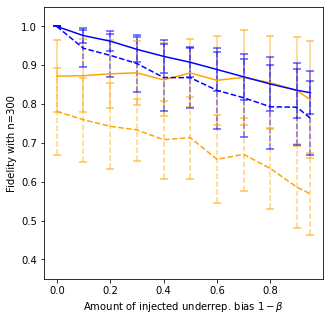

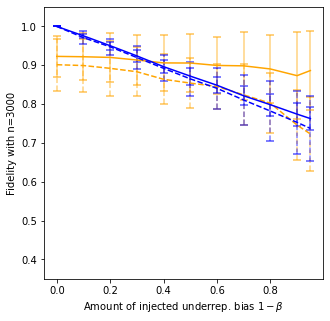

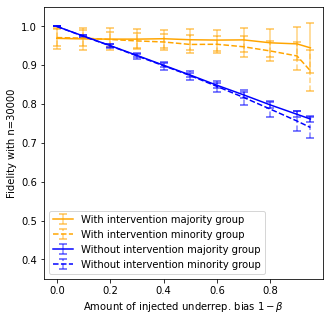

In [234]:
#Make plots for section 4

for n in [300,3000,30000]:

    eta = 0.4
    num_iters = 50

    df_fair = pd.read_csv(f'fid_with_intervention_numiters{num_iters}_n{n}_eta{eta}_fairnessTrue.csv')
    df_bias = pd.read_csv(f'fid_without_intervention_numiters{num_iters}_n{n}_eta{eta}_fairnessFalse.csv')

    a = 0.5
    fig, ax = plt.subplots(figsize=(5,5))
    markers, caps, bars = ax.errorbar(1-df_fair.bias_amts, df_fair.mean_fidel_maj, yerr = df_fair.y_err_fidel_maj, 
                                      label = 'With intervention majority group', color = "orange",
                                      capsize=4, capthick=2)
    [bar.set_alpha(a) for bar in bars]
    [cap.set_alpha(a) for cap in caps]
    markers, caps, bars = ax.errorbar(1-df_fair.bias_amts, df_fair.mean_fidel_min, yerr = df_fair.y_err_fidel_min, 
                                      label = 'With intervention minority group', color = "orange",
                                      capsize=4, capthick=2, linestyle='--')
    [bar.set_linestyle('--') for bar in bars]
    [bar.set_alpha(a) for bar in bars]
    [cap.set_alpha(a) for cap in caps]
    markers, caps, bars = ax.errorbar(1-df_bias.bias_amts, df_bias.mean_fidel_maj, yerr = df_bias.y_err_fidel_maj, 
                                      label = 'Without intervention majority group', color = "blue",
                                      capsize=4, capthick=2)
    [bar.set_alpha(a) for bar in bars]
    [cap.set_alpha(a) for cap in caps]
    markers, caps, bars = ax.errorbar(1-df_bias.bias_amts, df_bias.mean_fidel_min, yerr = df_bias.y_err_fidel_min, 
                                      label = 'Without intervention minority group', color = "blue",
                                      capsize=4, capthick=2, linestyle='--')
    [bar.set_linestyle('--') for bar in bars]
    [bar.set_alpha(a) for bar in bars]
    [cap.set_alpha(a) for cap in caps]
    
    #plt.errorbar(df_fair.bias_amts, df_fair.mean_fidel_maj, yerr = df_fair.y_err_fidel_maj, label = 'With intervention majority group', color = "orange")
    #plt.errorbar(df_fair.bias_amts, df_fair.mean_fidel_min, yerr = df_fair.y_err_fidel_min, label = 'With intervention minority group', color = "orange", linestyle = '--')
    #plt.errorbar(df_bias.bias_amts, df_bias.mean_fidel_maj, yerr = df_bias.y_err_fidel_maj, label = 'Without intervention majority group', color = "blue")
    #plt.errorbar(df_bias.bias_amts, df_bias.mean_fidel_min, yerr = df_bias.y_err_fidel_min, label = 'Without intervention minority group', color = "blue", linestyle = '--')
    #plt.errorbar(bias_amts, mean_fidel, yerr = y_err_fidel, label = 'Total Fidelity', color = "blue")
    
    plt.xlabel(r"Amount of injected underrep. bias $1-\beta$")
    plt.ylabel(f"Fidelity with n={n}")
    #plt.xlim(1.05, -0.05)
    plt.ylim(0.35, 1.05)
    if n == 30000:
        plt.legend()
    plt.savefig(f'section4_n{n}.jpg',dpi=300)
    plt.show()

# Exploration (Section 5)

## Representation

In [16]:
def representation(r, n, apply_fairness = True, verbose = False, num_iters = 10, inter = False, diff_base = False):
    
    empty_dict = dict()
    empty_dict['0.9'] = 0
    empty_dict['0.95'] = 0
    
    total_fidel_maj = []
    total_fidel_min = []
    total_fidel = []
    
    total_disp_bias_train = []
    total_disp_bo_train = []
    total_disp_mitigated_train = []
    
    total_disp_bias_test = []
    total_disp_bo_test = []
    total_disp_mitigated_test = []
    
    total_acc_bias_train = []
    total_acc_bo_train = []
    total_acc_mitigated_train = []
    
    total_acc_bias_test = []
    total_acc_bo_test = []
    total_acc_mitigated_test = []
    
    for i in range(num_iters):
    
        # 1 to 0 in increments of 0.1
        bias_amts = np.divide(list(range(10,-1,-1)),10)
        bias_amts[-1] = 0.05
        
        test_maj = []
        test_min = []
        total = []
        
        disp_bias_train = []
        disp_bo_train = []
        disp_mitigated_train = []
        
        disp_bias_test = []
        disp_bo_test = []
        disp_mitigated_test = []
        
        acc_bias_train = []
        acc_bo_train = []
        acc_mitigated_train = []
        
        acc_bias_test = []
        acc_bo_test = []
        acc_mitigated_test = []
        
        count = 0
        outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n, is_exploration=False)
        
        threshold = 0.5
        exact_bo_labels = np.where(outcome_continuous < threshold, 0, 1)
        exact_bo_labels_train = np.array(exact_bo_labels[range(0,n)])
        exact_bo_labels_test = np.array(exact_bo_labels[range(n,len(df_synthetic))])
        
        # split into train and test
        df_train = df_synthetic.loc[range(0,n), :]
        #check_groups(df_train)
        
        df_train_transf, maj_list, min_list = transform(df_train, True, True)
        
        df_test = df_synthetic.loc[range(n, len(df_synthetic)),:]
        df_maj = df_test[df_test['cat'] == 1]
        df_min = df_test[df_test['cat'] == 0]
        #check_groups(df_test)
        df_test_transf, maj_list, min_list = transform(df_test, True, False)
        
        df_test_maj = df_test_transf.loc[maj_list]
        df_test_min = df_test_transf.loc[min_list]

        # format training data
        X_true = df_train_transf.iloc[:, :-2].values
        y_true = df_train_transf.iloc[:, -1].values
        
        # format test data
        X_test = df_test_transf.iloc[:, :-2].values
        X_test_maj = df_test_maj.iloc[:, :-2].values
        X_test_min = df_test_min.iloc[:, :-2].values
        y_test = df_test_transf.iloc[:, -1].values
        y_test_maj = df_test_maj.iloc[:, -1].values
        y_test_min = df_test_min.iloc[:, -1].values
        
        sens_attr_test = df_test['cat']
        sens_attr_maj = df_maj['cat']
        sens_attr_min = df_min['cat']
        
        for beta in bias_amts:
            
            if i == 0: print("Beta: ", beta, '\n')

            df_train_copy = df_train.copy()

            df_majority = df_train_copy[df_train_copy['cat'] == 1]
            df_minority = df_train_copy[df_train_copy['cat'] == 0]

            if inter:
                # unfavored group with negative label
                df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

                # unfavored group with positive label (preferred)
                df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

                # data frame without positively labeled examples from minority class
                df_total = pd.concat([df_majority, df_minority_negative])

                df_undersampled, is_empty = under(df_minority_positive, beta)

                # combine undersampled and original favored class to create dataset
                df_concat = pd.concat([df_total,df_undersampled]).sample(frac=1, random_state = 42) # permute data

            else:
                df_undersampled, is_empty = under(df_minority, beta)

                # combine undersampled and original favored class to create dataset
                df_concat = pd.concat([df_majority,df_undersampled])
                df_concat.sample(frac=1, random_state = 42) # permute data

            if is_empty:
                empty_dict[str(1-beta)] += 1
                print(empty_dict)
            
            # format data
            X_bias_true, y_bias_true, df_sens = transform(df_concat)
            
            # model trained on biased data
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_bias = classifier.fit(X_bias_true, y_bias_true)
            
            acc = accuracy_score(y_test,classifier_bias.predict(X_test))
            #print(f'Biased classifier:')
            #print(f'     Test accuracy = {acc}')
            acc_bias_test += [acc]
            acc_bias_train += [accuracy_score(y_bias_true, classifier_bias.predict(X_bias_true))]
            
            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bias_train += [disparity.gamma(classify).max()]

            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bias_test += [disparity.gamma(classify).max()]
            
            # Learned bayes optimal classifier
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_b = classifier.fit(X_true, y_true)        
            #print('COEF: ', classifier_b.coef_)
            #print('INTERCEPT: ', classifier_b.intercept_)
            #classifier_b = clone(classifier).fit(X_true, y_true)
            acc = accuracy_score(y_test,classifier_b.predict(X_test))
            #print(f'Learned BO classifier:')
            #print(f'     Test accuracy = {acc}')
            acc_bo_test += [acc]
            acc_bo_train += [accuracy_score(y_bias_true, classifier_b.predict(X_bias_true))]
            
            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bo_train += [disparity.gamma(classify).max()]

            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bo_test += [disparity.gamma(classify).max()]
            
            
            # Exact BO optimal classifier
            #print(f'Exact BO classifier:')
            acc = accuracy_score(y_test,exact_bo_labels_test)
            #print(f'     Test accuracy = {acc}')
            acc = accuracy_score(y_true,exact_bo_labels_train)
            #print(f'     Train accuracy = {acc}')

            if apply_fairness:
                if not is_empty:
                    constraint = EqualizedOdds()
                    classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none', fit_intercept = False, max_iter = 200)   

    #                 classifier_mitigated_bias = GridSearch(estimator=classifier,
    #                                                        constraints=constraint,
    #                                                        selection_rule='tradeoff_optimization',
    #                                                        constraint_weight=0.5,
    #                                                        grid_size=10,
    #                                                        grid_limit=2.0,
    #                                                        grid_offset=None,
    #                                                        grid=None,
    #                                                        sample_weight_name='sample_weight')

                    classifier_mitigated_bias = ThresholdOptimizer(estimator=clone(classifier_bias), constraints= 'equalized_odds', predict_method='auto')

                    classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)

                    #acc = accuracy_score(y_test,classifier_mitigated_bias.predict(X_test))
                    acc = accuracy_score(y_test,classifier_mitigated_bias.predict(X_test, sensitive_features=sens_attr_test))
                    #print(f'Mitigated bias classifier:')
                    #print(f'     Test accuracy = {acc}')
                    acc_mitigated_test += [acc]
                    #acc_mitigated_train += [accuracy_score(y_bias_true, classifier_mitigated_bias.predict(X_bias_true))]
                    acc_mitigated_train += [accuracy_score(y_bias_true, classifier_mitigated_bias.predict(X_bias_true, sensitive_features=df_sens))]

                    m = classifier_mitigated_bias
                    def classify(X): return m.predict(X, sensitive_features = df_sens)
                    error = ErrorRate()
                    error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                    disparity = EqualizedOdds()
                    disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                    #print(f'     Train error = {error.gamma(classify)[0]}')
                    #print(f'     Train disparity = {disparity.gamma(classify).max()}')
                    disp_mitigated_train += [disparity.gamma(classify).max()]

                    m = classifier_mitigated_bias
                    def classify(X): return m.predict(X, sensitive_features = sens_attr_test)
                    error = ErrorRate()
                    error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                    disparity = EqualizedOdds()
                    disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                    #print(f'     Test error = {error.gamma(classify)[0]}')
                    #print(f'     Test disparity = {disparity.gamma(classify).max()}')
                    disp_mitigated_test += [disparity.gamma(classify).max()]

                    # Alternative fidelity of intervention model to no intervention model
                    alt_fid_train = accuracy_score(classifier_mitigated_bias.predict(X_bias_true, sensitive_features = df_sens),classifier_bias.predict(X_bias_true))
                    alt_fid_test = accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test),classifier_bias.predict(X_test))
                    #print(f'Alternative fidelity of intervention model to no intervention model: train = {alt_fid_train}, test = {alt_fid_test}')
                else:
                    disp_mitigated_train += [np.nan]
                    disp_mitigated_test += [np.nan]

                    acc_mitigated_train += [np.nan]
                    acc_mitigated_test += [np.nan]

            else:
                classifier_mitigated_bias = clone(classifier_bias)
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true)
                
                disp_mitigated_train += [0]
                disp_mitigated_test += [0]
                
                acc_mitigated_train += [0]
                acc_mitigated_test += [0]
                
                # NOTE: disparities are the same as for classifier_bias

            
            if not is_empty:
                if apply_fairness:
                    # Fidelity in this step
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test),classifier_b.predict(X_test))
                    #print(f'Test set fidelity of learned BO classifier and mitigated_bias_classifier: {fid}')
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test),exact_bo_labels_test)
                    #print(f'Test set fidelity of exact BO classifier and mitigated biased classifier: {fid}')
                else:
                    # Fidelity in this step
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test),classifier_b.predict(X_test))
                    #print(f'Test set fidelity of learned BO classifier and mitigated_bias_classifier: {fid}')
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test),exact_bo_labels_test)
                    #print(f'Test set fidelity of exact BO classifier and mitigated biased classifier: {fid}')
                
            fid = accuracy_score(classifier_bias.predict(X_test),classifier_b.predict(X_test))
            #print(f'Test set fidelity of learned BO classifier and biased classifier: {fid}')
            
            if not is_empty:
                if apply_fairness:
                    # fidelity check
                    test_maj += [accuracy_score(classifier_mitigated_bias.predict(X_test_maj, sensitive_features = sens_attr_maj), classifier_b.predict(X_test_maj))]
                    #print(test_maj)
                    test_min += [accuracy_score(classifier_mitigated_bias.predict(X_test_min, sensitive_features = sens_attr_min), classifier_b.predict(X_test_min))]
                    #print(test_min)
                    total += [accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test), classifier_b.predict(X_test))]
                else:
                    # fidelity check
                    test_maj += [accuracy_score(classifier_mitigated_bias.predict(X_test_maj), classifier_b.predict(X_test_maj))]
                    #print(test_maj)
                    test_min += [accuracy_score(classifier_mitigated_bias.predict(X_test_min), classifier_b.predict(X_test_min))]
                    #print(test_min)
                    total += [accuracy_score(classifier_mitigated_bias.predict(X_test), classifier_b.predict(X_test))]
            else:
                test_maj += [np.nan]
                test_min += [np.nan]
                total += [np.nan]
                
            if verbose:
                #print("Finished Iteration: ", count)
                count +=1
        
        #print(f'Fidelity test maj: {test_maj}')
        #print(f'Fidelity test min: {test_maj}')
        
        total_fidel_maj.append(test_maj)
        total_fidel_min.append(test_min)
        total_fidel.append(total)
        
        total_disp_bias_train.append(disp_bias_train)
        total_disp_bo_train.append(disp_bo_train)
        total_disp_mitigated_train.append(disp_mitigated_train)

        total_disp_bias_test.append(disp_bias_test)
        total_disp_bo_test.append(disp_bo_test)
        total_disp_mitigated_test.append(disp_mitigated_test)
        
        total_acc_bias_train.append(acc_bias_train)
        total_acc_bo_train.append(acc_bo_train)
        total_acc_mitigated_train.append(acc_mitigated_train)

        total_acc_bias_test.append(acc_bias_test)
        total_acc_bo_test.append(acc_bo_test)
        total_acc_mitigated_test.append(acc_mitigated_test)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
    
    mean_fidel_maj = remove_nan(total_fidel_maj)
    mean_fidel_min = remove_nan(total_fidel_min)
    mean_fidel = remove_nan(total_fidel)
    
    mean_disp_bias_train = remove_nan(total_disp_bias_train)
    mean_disp_bo_train = remove_nan(total_disp_bo_train)
    mean_disp_mitigated_train = remove_nan(total_disp_mitigated_train)
    
    mean_disp_bias_test = remove_nan(total_disp_bias_test)
    mean_disp_bo_test = remove_nan(total_disp_bo_test)
    mean_disp_mitigated_test = remove_nan(total_disp_mitigated_test)
    
    mean_acc_bias_train = remove_nan(total_acc_bias_train)
    mean_acc_bo_train = remove_nan(total_acc_bo_train)
    mean_acc_mitigated_train = remove_nan(total_acc_mitigated_train)
    
    mean_acc_bias_test = remove_nan(total_acc_bias_test)
    mean_acc_bo_test = remove_nan(total_acc_bo_test)
    mean_acc_mitigated_test = remove_nan(total_acc_mitigated_test)
    
    y_err_fidel_maj = remove_nan_std(total_fidel_maj)
    y_err_fidel_min = remove_nan_std(total_fidel_min)
    y_err_fidel = remove_nan_std(total_fidel)
    
    
    df_disp = pd.DataFrame({"Biased Train" : mean_disp_bias_train,
                       "BO Train" : mean_disp_bo_train,
                       "Mitigated Train" : mean_disp_mitigated_train,
                       "Biased Test" : mean_disp_bias_test,
                       "BO Test" : mean_disp_bo_test,
                       "Mitigated Test" : mean_disp_mitigated_test})
    
    df_acc = pd.DataFrame({"Biased Train" : mean_acc_bias_train,
                       "BO Train" : mean_acc_bo_train,
                       "Mitigated Train" : mean_acc_mitigated_train,
                       "Biased Test" : mean_acc_bias_test,
                       "BO Test" : mean_acc_bo_test,
                       "Mitigated Test" : mean_acc_mitigated_test})
   
    return bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df_disp, df_acc

In [17]:
random.seed(42)
np.random.seed(42)

eta = 0.4
n = 30000
r = 0.2
num_iters = 50

bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df_disp, df_acc = \
representation(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = False, inter = False)

df_res = pd.DataFrame(np.array([bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel]).T,
                      columns=['bias_amts', 'mean_fidel_maj', 'mean_fidel_min', 'mean_fidel', 'y_err_fidel_maj', 'y_err_fidel_min', 'y_err_fidel'])
df_disp.to_csv(f'disp_repr_no_inter.csv', index = True)
df_res.to_csv(f'fid_repr_no_inter.csv', index = True)
df_acc.to_csv(f'acc_repr_no_inter.csv', index = True)

Diff:  0.008458333333333345
Beta:  1.0 

Total Deleted:  0 	 % Deleted:  0.0
Beta:  0.9 

Total Deleted:  601 	 % Deleted:  0.10145172180958811
Beta:  0.8 

Total Deleted:  1236 	 % Deleted:  0.2086428089128967
Beta:  0.7 

Total Deleted:  1809 	 % Deleted:  0.30536799459824443


KeyboardInterrupt: 

In [18]:
random.seed(42)
np.random.seed(42)

eta = 0.4
n = 30000
r = 0.2
num_iters = 50

bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df_disp, df_acc = \
representation(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = False, inter = True)

df_res = pd.DataFrame(np.array([bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel]).T,
                      columns=['bias_amts', 'mean_fidel_maj', 'mean_fidel_min', 'mean_fidel', 'y_err_fidel_maj', 'y_err_fidel_min', 'y_err_fidel'])
df_disp.to_csv(f'disp_repr_inter.csv', index = True)
df_res.to_csv(f'fid_repr_inter.csv', index = True)
df_acc.to_csv(f'acc_repr_inter.csv', index = True)

Diff:  0.008458333333333345
Beta:  1.0 

Total Deleted:  0 	 % Deleted:  0.0
Beta:  0.9 

Total Deleted:  298 	 % Deleted:  0.10215975317106617


KeyboardInterrupt: 

In [19]:
random.seed(42)
np.random.seed(42)

eta = 0.4
n = 30000
r = 0.2
num_iters = 50

bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df_disp, df_acc = \
representation(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = True, inter = True)

df_res = pd.DataFrame(np.array([bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel]).T,
                      columns=['bias_amts', 'mean_fidel_maj', 'mean_fidel_min', 'mean_fidel', 'y_err_fidel_maj', 'y_err_fidel_min', 'y_err_fidel'])
df_disp.to_csv(f'disp_repr_diff_base.csv', index = True)
df_res.to_csv(f'fid_repr_diff_base.csv', index = True)
df_acc.to_csv(f'acc_repr_diff_base.csv', index = True)

Diff:  0.008458333333333345
Beta:  1.0 

Total Deleted:  0 	 % Deleted:  0.0
Beta:  0.9 

Total Deleted:  298 	 % Deleted:  0.10215975317106617


KeyboardInterrupt: 

## Label Noise

In [20]:
def flip(df, eta):
    labels = copy.deepcopy(list(df['outcome'].values))
    #print('Before:', df['outcome_flipped'].value_counts())
    num_flipped = 0
    for i in range(len(labels)):
        if random.uniform(0,1) <= eta:
            labels[i] = 1 if labels[i] == 0 else 0
            num_flipped += 1
    df['outcome_flipped'] = labels
    #print('After:', df['outcome_flipped'].value_counts())
    print('Pos Min Flipped: ', num_flipped, "\tRate: ", num_flipped / len(df))
    return df

def get_noise(df, beta, inter = False, is_init = True):
    df_majority = df[df['cat'] == 1]
    df_minority = df[df['cat'] == 0]
    
    if inter:
        # unfavored group with negative label
        df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

        # unfavored group with positive label (preferred)
        df_minority_positive = df_minority[df_minority['outcome'] == 1.0]
        
        if is_init:
            
            df_undersampled_majog = flip(df_majority, 0.4)
        
            df_undersampled_maj = flip(df_minority_negative, 0.4)

            df_undersampled = flip(df_minority_positive, beta)

            df_concat = pd.concat([df_undersampled_majog,df_undersampled_maj,df_undersampled])
            
        else:
            
            df_total = pd.concat([df_majority, df_minority_negative])
            
            df_undersampled = flip(df_minority_positive, beta)
            
            df_concat = pd.concat([df_total,df_undersampled])
        

        return df_concat.sample(frac=1, random_state = 42) # permute data
    
    else:
        df_undersampled = flip(df_minority, beta)

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_majority,df_undersampled])

        return df_concat.sample(frac=1, random_state = 42) # permute data

In [21]:
def label_noise(r, n, apply_fairness = True, verbose = False, num_iters = 10, inter = False, diff_base = False):
    
    total_fidel_maj = []
    total_fidel_min = []
    total_fidel = []
    
    total_disp_bias_train = []
    total_disp_bo_train = []
    total_disp_mitigated_train = []
    
    total_disp_bias_test = []
    total_disp_bo_test = []
    total_disp_mitigated_test = []
    
    for i in range(num_iters):
    
        # 1 to 0 in increments of 0.1
        bias_amts = np.divide(list(range(0,10,1)),20)

        test_maj = []
        test_min = []
        total = []
        
        disp_bias_train = []
        disp_bo_train = []
        disp_mitigated_train = []
        
        disp_bias_test = []
        disp_bo_test = []
        disp_mitigated_test = []
        
        count = 0
        
        if diff_base: 
            #outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n, maj_means =[0.7,0.7,0.7], is_exploration = True)
            _, df_train = true_label_generation(r=r, eta=eta, n=n, maj_means =[0.7,0.7,0.7], is_exploration = True)
            _, df_test = true_label_generation(r=r, eta=eta, n=n, maj_means =[0.7,0.7,0.7], is_exploration = False)
        else: 
            print('generating train')
            _, df_train = true_label_generation(r=r, eta=eta, n=n, is_exploration = True, inter = inter)
            print('\ngenerating test')
            _, df_test = true_label_generation(r=r, eta=eta, n=n, is_exploration = False, inter = True) 
            #_, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n, is_exploration = False) 
            
        threshold = 0.5
        exact_bo_labels = np.where(outcome_continuous < threshold, 0, 1)
        exact_bo_labels_train = np.array(exact_bo_labels[range(0,n)])
        exact_bo_labels_test = np.array(exact_bo_labels[range(n,len(df_synthetic))])
        
        # split into train and test
        #df_train = df_synthetic.loc[range(0,n), :]
        
        #df_train = get_noise(df_train, 0, inter = True)
        #print("true train")
        #check_groups(df_train)
        
        df_train_bo = get_noise(df_train.copy(), 0.4, inter = inter, is_init = False)
        #print("true train with pos min noise")
        #check_groups(df_train_bo)
        
        X_true, y_true, df_sens_true = transform(df_train_bo, False, True)
        is_empty = False
        
        # format training data
        #X_true = df_train_transf_bo.iloc[:, :-2].values
        #y_true = df_train_transf_bo.iloc[:, -1].values
        
        #df_test = df_synthetic.loc[range(n, len(df_synthetic)),:]
        #print("test")
        #check_groups(df_test)
        
        #df_train_transf, maj_list, min_list = transform(df_train, True, True)
        
        #df_test = get_noise(df_test, 0, inter = True)
        df_maj = df_test[df_test['cat'] == 1]
        df_min = df_test[df_test['cat'] == 0]
        
        df_test_transf, maj_list, min_list = transform(df_test, True, True)
        
        df_test_maj = df_test_transf.loc[maj_list]
        df_test_min = df_test_transf.loc[min_list]
        
        # format test data
        X_test = df_test_transf.iloc[:, :-2].values
        X_test_maj = df_test_maj.iloc[:, :-2].values
        X_test_min = df_test_min.iloc[:, :-2].values
        y_test = df_test_transf.iloc[:, -1].values
        y_test_maj = df_test_maj.iloc[:, -1].values
        y_test_min = df_test_min.iloc[:, -1].values
        
        sens_attr_test = df_test['cat']
        sens_attr_maj = df_maj['cat']
        sens_attr_min = df_min['cat']
        
        for beta in bias_amts: #[0.4]
            
            if i == 0: print("Beta: ", beta, '\n')

            df_train_copy = df_train.copy()
            
            df_concat = get_noise(df_train_copy, beta, inter, is_init = False) # group-dependent label noise
            #print("biased train")
            #check_groups(df_concat)

            # format data
            X_bias_true, y_bias_true, df_sens = transform(df_concat)
            
            # model trained on biased data
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            if beta == 0.4:
                classifier_bias = classifier.fit(X_true, y_true)
            else:
                classifier_bias = classifier.fit(X_bias_true, y_bias_true)
            
            acc = accuracy_score(y_test,classifier_bias.predict(X_test))
            #print(f'Biased classifier:')
            #print(f'     Test accuracy = {acc}')
            
            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bias_train += [disparity.gamma(classify).max()]

            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bias_test += [disparity.gamma(classify).max()]
            
            # Learned bayes optimal classifier
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_b = classifier.fit(X_true, y_true)                
            #classifier_b = clone(classifier).fit(X_true, y_true)
            acc = accuracy_score(y_test,classifier_b.predict(X_test))
            #print(f'Learned BO classifier:')
            #print(f'     Test accuracy = {acc}')
            
            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bo_train += [disparity.gamma(classify).max()]

            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bo_test += [disparity.gamma(classify).max()]
            
            
            # Exact BO optimal classifier
            #print(f'Exact BO classifier:')
            acc = accuracy_score(y_test,exact_bo_labels_test)
            #print(f'     Test accuracy = {acc}')
            acc = accuracy_score(y_true,exact_bo_labels_train)
            #print(f'     Train accuracy = {acc}')

            if apply_fairness:
                if not is_empty:
                    constraint = EqualizedOdds()
                    classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none', fit_intercept = False, max_iter = 200)   

    #                 classifier_mitigated_bias = GridSearch(estimator=classifier,
    #                                                        constraints=constraint,
    #                                                        selection_rule='tradeoff_optimization',
    #                                                        constraint_weight=0.5,
    #                                                        grid_size=10,
    #                                                        grid_limit=2.0,
    #                                                        grid_offset=None,
    #                                                        grid=None,
    #                                                        sample_weight_name='sample_weight')

                    classifier_mitigated_bias = ThresholdOptimizer(estimator=clone(classifier_bias), constraints= 'equalized_odds', predict_method='auto')

                    classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)

                    #acc = accuracy_score(y_test,classifier_mitigated_bias.predict(X_test))
                    acc = accuracy_score(y_test,classifier_mitigated_bias.predict(X_test, sensitive_features=sens_attr_test))
                    #print(f'Mitigated bias classifier:')
                    #print(f'     Test accuracy = {acc}')
                    #acc_mitigated_test += [acc]
                    #acc_mitigated_train += [accuracy_score(y_bias_true, classifier_mitigated_bias.predict(X_bias_true))]
                    #acc_mitigated_train += [accuracy_score(y_bias_true, classifier_mitigated_bias.predict(X_bias_true, sensitive_features=df_sens))]

                    m = classifier_mitigated_bias
                    def classify(X): return m.predict(X, sensitive_features = df_sens)
                    error = ErrorRate()
                    error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                    disparity = EqualizedOdds()
                    disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                    #print(f'     Train error = {error.gamma(classify)[0]}')
                    #print(f'     Train disparity = {disparity.gamma(classify).max()}')
                    disp_mitigated_train += [disparity.gamma(classify).max()]

                    m = classifier_mitigated_bias
                    def classify(X): return m.predict(X, sensitive_features = sens_attr_test)
                    error = ErrorRate()
                    error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                    disparity = EqualizedOdds()
                    disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                    #print(f'     Test error = {error.gamma(classify)[0]}')
                    #print(f'     Test disparity = {disparity.gamma(classify).max()}')
                    disp_mitigated_test += [disparity.gamma(classify).max()]

                    # Alternative fidelity of intervention model to no intervention model
                    alt_fid_train = accuracy_score(classifier_mitigated_bias.predict(X_bias_true, sensitive_features = df_sens),classifier_bias.predict(X_bias_true))
                    alt_fid_test = accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test),classifier_bias.predict(X_test))
                    #print(f'Alternative fidelity of intervention model to no intervention model: train = {alt_fid_train}, test = {alt_fid_test}')
                else:
                    disp_mitigated_train += [np.nan]
                    disp_mitigated_test += [np.nan]

#                     acc_mitigated_train += [np.nan]
#                     acc_mitigated_test += [np.nan]

            else:
                classifier_mitigated_bias = clone(classifier_bias)
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true)
                
                disp_mitigated_train += [0]
                disp_mitigated_test += [0]
                
#                 acc_mitigated_train += [0]
#                 acc_mitigated_test += [0]
                
                # NOTE: disparities are the same as for classifier_bias

            
            if not is_empty:
                if apply_fairness:
                    # Fidelity in this step
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test),classifier_b.predict(X_test))
                    #print(f'Test set fidelity of learned BO classifier and mitigated_bias_classifier: {fid}')
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test),exact_bo_labels_test)
                    #print(f'Test set fidelity of exact BO classifier and mitigated biased classifier: {fid}')
                else:
                    # Fidelity in this step
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test),classifier_b.predict(X_test))
                    #print(f'Test set fidelity of learned BO classifier and mitigated_bias_classifier: {fid}')
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test),exact_bo_labels_test)
                    #print(f'Test set fidelity of exact BO classifier and mitigated biased classifier: {fid}')
                
            fid = accuracy_score(classifier_bias.predict(X_test),classifier_b.predict(X_test))
            #print(f'Test set fidelity of learned BO classifier and biased classifier: {fid}')
            
            if not is_empty:
                if apply_fairness:
                    # fidelity check
                    test_maj += [accuracy_score(classifier_mitigated_bias.predict(X_test_maj, sensitive_features = sens_attr_maj), classifier_b.predict(X_test_maj))]
                    #print(test_maj)
                    test_min += [accuracy_score(classifier_mitigated_bias.predict(X_test_min, sensitive_features = sens_attr_min), classifier_b.predict(X_test_min))]
                    #print(test_min)
                    total += [accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test), classifier_b.predict(X_test))]
                else:
                    # fidelity check
                    test_maj += [accuracy_score(classifier_mitigated_bias.predict(X_test_maj), classifier_b.predict(X_test_maj))]
                    #print(test_maj)
                    test_min += [accuracy_score(classifier_mitigated_bias.predict(X_test_min), classifier_b.predict(X_test_min))]
                    #print(test_min)
                    total += [accuracy_score(classifier_mitigated_bias.predict(X_test), classifier_b.predict(X_test))]
            else:
                test_maj += [np.nan]
                test_min += [np.nan]
                total += [np.nan]
                
            if verbose:
                #print("Finished Iteration: ", count)
                count +=1
        
        #print(f'Fidelity test maj: {test_maj}')
        #print(f'Fidelity test min: {test_maj}')
        
        total_fidel_maj.append(test_maj)
        total_fidel_min.append(test_min)
        total_fidel.append(total)
        
        total_disp_bias_train.append(disp_bias_train)
        total_disp_bo_train.append(disp_bo_train)
        total_disp_mitigated_train.append(disp_mitigated_train)

        total_disp_bias_test.append(disp_bias_test)
        total_disp_bo_test.append(disp_bo_test)
        total_disp_mitigated_test.append(disp_mitigated_test)
        
#         total_acc_bias_train.append(acc_bias_train)
#         total_acc_bo_train.append(acc_bo_train)
#         total_acc_mitigated_train.append(acc_mitigated_train)

#         total_acc_bias_test.append(acc_bias_test)
#         total_acc_bo_test.append(acc_bo_test)
#         total_acc_mitigated_test.append(acc_mitigated_test)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
    
    mean_fidel_maj = remove_nan(total_fidel_maj)
    mean_fidel_min = remove_nan(total_fidel_min)
    mean_fidel = remove_nan(total_fidel)
    
    mean_disp_bias_train = remove_nan(total_disp_bias_train)
    mean_disp_bo_train = remove_nan(total_disp_bo_train)
    mean_disp_mitigated_train = remove_nan(total_disp_mitigated_train)
    
    mean_disp_bias_test = remove_nan(total_disp_bias_test)
    mean_disp_bo_test = remove_nan(total_disp_bo_test)
    mean_disp_mitigated_test = remove_nan(total_disp_mitigated_test)
    
#     mean_acc_bias_train = remove_nan(total_acc_bias_train)
#     mean_acc_bo_train = remove_nan(total_acc_bo_train)
#     mean_acc_mitigated_train = remove_nan(total_acc_mitigated_train)
    
#     mean_acc_bias_test = remove_nan(total_acc_bias_test)
#     mean_acc_bo_test = remove_nan(total_acc_bo_test)
#     mean_acc_mitigated_test = remove_nan(total_acc_mitigated_test)
    
    y_err_fidel_maj = remove_nan_std(total_fidel_maj)
    y_err_fidel_min = remove_nan_std(total_fidel_min)
    y_err_fidel = remove_nan_std(total_fidel)
    
    
    df_disp = pd.DataFrame({"Biased Train" : mean_disp_bias_train,
                       "BO Train" : mean_disp_bo_train,
                       "Mitigated Train" : mean_disp_mitigated_train,
                       "Biased Test" : mean_disp_bias_test,
                       "BO Test" : mean_disp_bo_test,
                       "Mitigated Test" : mean_disp_mitigated_test})
    
#     df_acc = pd.DataFrame({"Biased Train" : mean_acc_bias_train,
#                        "BO Train" : mean_acc_bo_train,
#                        "Mitigated Train" : mean_acc_mitigated_train,
#                        "Biased Test" : mean_acc_bias_test,
#                        "BO Test" : mean_acc_bo_test,
#                        "Mitigated Test" : mean_acc_mitigated_test})
   
    return bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df_disp#, df_acc

In [22]:
random.seed(42)
np.random.seed(42)

eta = 0.4
n = 30000
r = 0.2
num_iters = 50

bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df = \
label_noise(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = False, inter = False)

df.to_csv('disp_label_noise_no_inter.csv', index = True)
df_res = pd.DataFrame(np.array([bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel,
                                y_err_fidel_maj, y_err_fidel_min, y_err_fidel]).T,
                      columns=['bias_amts', 'mean_fidel_maj', 'mean_fidel_min', 'mean_fidel', 'y_err_fidel_maj', 'y_err_fidel_min', 'y_err_fidel'])
df_res.to_csv(f'fid_label_noise_no_inter.csv', index = True)

generating train
Diff:  0.008583333333333332
Num Flipped Maj:  9594 	Rate:  0.39975

generating test
Diff:  -0.0010000000000000009
Pos Min Flipped:  2387 	Rate:  0.3978333333333333
Beta:  0.0 

Pos Min Flipped:  0 	Rate:  0.0
Beta:  0.05 

Pos Min Flipped:  296 	Rate:  0.04933333333333333


KeyboardInterrupt: 

In [23]:
random.seed(42)
np.random.seed(42)

eta = 0.4
n = 30000
r = 0.2
num_iters = 50

bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df = \
label_noise(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = False, inter = True)

df.to_csv('disp_label_noise_inter.csv', index = True)
df_res = pd.DataFrame(np.array([bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel,
                                y_err_fidel_maj, y_err_fidel_min, y_err_fidel]).T,
                      columns=['bias_amts', 'mean_fidel_maj', 'mean_fidel_min', 'mean_fidel', 'y_err_fidel_maj', 'y_err_fidel_min', 'y_err_fidel'])
df_res.to_csv(f'fid_label_noise_inter.csv', index = True)

generating train
Diff:  0.008583333333333332
Num Flipped Maj:  9594 	Rate:  0.39975
Num Flipped Min Neg:  1195 	Rate:  0.3941292875989446

generating test
Diff:  -0.0010000000000000009
Pos Min Flipped:  1159 	Rate:  0.39049865229110514
Beta:  0.0 

Pos Min Flipped:  0 	Rate:  0.0
Beta:  0.05 

Pos Min Flipped:  143 	Rate:  0.04818059299191375


KeyboardInterrupt: 

In [24]:
random.seed(42)
np.random.seed(42)

eta = 0.4
n = 30000
r = 0.2
num_iters = 50

bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df = \
label_noise(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = True, inter = True)

df.to_csv('disp_label_noise_diff_base.csv', index = True)
df_res = pd.DataFrame(np.array([bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel]).T, columns=['bias_amts', 'mean_fidel_maj', 'mean_fidel_min', 'mean_fidel', 'y_err_fidel_maj', 'y_err_fidel_min', 'y_err_fidel'])
df_res.to_csv(f'fid_label_noise_diff_base.csv', index = True)

Diff:  0.20808333333333334
Num Flipped Maj:  9594 	Rate:  0.39975
Num Flipped Min Neg:  1195 	Rate:  0.3941292875989446
Diff:  0.19770833333333326
Pos Min Flipped:  1159 	Rate:  0.39049865229110514
Beta:  0.0 

Pos Min Flipped:  0 	Rate:  0.0
Beta:  0.05 

Pos Min Flipped:  143 	Rate:  0.04818059299191375


KeyboardInterrupt: 

## Feature Noise/Missingness

In [25]:
def inject_noise_num(df, feature, eta, eps = 1):
    feats = df[feature].values
    #print('Before:', df_synthetic['outcome'].value_counts())
    num_flipped = 0
    for i in range(len(feats)):
        if random.uniform(0,1) <= eta:
            feats[i] = 0
            num_flipped += 1
    df[feature] = feats
    print('Num Flipped: ', num_flipped, "\tRate: ", num_flipped / len(df))
    return df

# measurement bias
def get_biased_data(df, eps, inter):
    df_majority = df[df['cat'] == 1]
    df_minority = df[df['cat'] == 0]
    
    if inter:
    
        # unfavored group with negative label
        df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

        # unfavored group with positive label (preferred)
        df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

        # data frame without positively labeled examples from minority class
        df_total = pd.concat([df_majority, df_minority_negative])

        # under-sampling process
        df_bias = inject_noise_num(df_minority_positive, 'num1', eps)

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_total,df_bias])
    
    else:
        # under-sampling process
        df_bias = inject_noise_num(df_minority, 'num1', eps)
        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_majority,df_bias])
    
    return df_concat.sample(frac=1, random_state = 42) # permute data

In [26]:
def measurement(r, n, apply_fairness = True, verbose = False, num_iters = 10, inter = False, diff_base = False):
    
    empty_dict = dict()
    empty_dict['0.9'] = 0
    empty_dict['0.95'] = 0
    
    total_fidel_maj = []
    total_fidel_min = []
    total_fidel = []
    
    total_disp_bias_train = []
    total_disp_bo_train = []
    total_disp_mitigated_train = []
    
    total_disp_bias_test = []
    total_disp_bo_test = []
    total_disp_mitigated_test = []
    
    total_acc_bias_train = []
    total_acc_bo_train = []
    total_acc_mitigated_train = []
    
    total_acc_bias_test = []
    total_acc_bo_test = []
    total_acc_mitigated_test = []
    
    for i in range(num_iters):
    
        bias_amts = np.divide(list(range(0,11,1)),10)

        test_maj = []
        test_min = []
        total = []
        
        disp_bias_train = []
        disp_bo_train = []
        disp_mitigated_train = []
        
        disp_bias_test = []
        disp_bo_test = []
        disp_mitigated_test = []
        
        acc_bias_train = []
        acc_bo_train = []
        acc_mitigated_train = []

        acc_bias_test = []
        acc_bo_test = []
        acc_mitigated_test = []
        
        count = 0
        
        if diff_base: 
            outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n, maj_means =[0.7,0.7,0.7])
        else: outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n)        
        
        threshold = 0.5
        exact_bo_labels = np.where(outcome_continuous < threshold, 0, 1)
        exact_bo_labels_train = np.array(exact_bo_labels[range(0,n)])
        exact_bo_labels_test = np.array(exact_bo_labels[range(n,len(df_synthetic))])
        
        # split into train and test
        df_train = df_synthetic.loc[range(0,n), :]
        
        df_train_transf, maj_list, min_list = transform(df_train, True, True)
        
        df_test = df_synthetic.loc[range(n, len(df_synthetic)),:]
        df_maj = df_test[df_test['cat'] == 1]
        df_min = df_test[df_test['cat'] == 0]
        
        df_test_transf, maj_list, min_list = transform(df_test, True, False)
        
        df_test_maj = df_test_transf.loc[maj_list]
        df_test_min = df_test_transf.loc[min_list]

        # format training data
        X_true = df_train_transf.iloc[:, :-2].values
        y_true = df_train_transf.iloc[:, -1].values
        
        # format test data
        X_test = df_test_transf.iloc[:, :-2].values
        X_test_maj = df_test_maj.iloc[:, :-2].values
        X_test_min = df_test_min.iloc[:, :-2].values
        y_test = df_test_transf.iloc[:, -1].values
        y_test_maj = df_test_maj.iloc[:, -1].values
        y_test_min = df_test_min.iloc[:, -1].values
        
        sens_attr_test = df_test['cat']
        sens_attr_maj = df_maj['cat']
        sens_attr_min = df_min['cat']
        
        
        for beta in bias_amts:
            
            if i == 0: print("Beta: ", beta, '\n')

            df_train_copy = df_train.copy()

            df_majority = df_train_copy[df_train_copy['cat'] == 1]
            df_minority = df_train_copy[df_train_copy['cat'] == 0]

            # unfavored group with negative label
            df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

            # unfavored group with positive label (preferred)
            df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

            # data frame without positively labeled examples from minority class
            df_total = pd.concat([df_majority, df_minority_negative])

            # under-sampling process
            df_undersampled, is_empty = under(df_minority_positive, 1)
            
            if is_empty:
                empty_dict[str(1-beta)] += 1
                print(empty_dict)

            # combine undersampled and original favored class to create dataset
            df_concat1 = pd.concat([df_total,df_undersampled])
            
            df_concat = get_biased_data(df_concat1, beta, inter)

            # format data
            X_bias_true, y_bias_true, df_sens = transform(df_concat)
            
            # model trained on biased data
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_bias = classifier.fit(X_bias_true, y_bias_true)
            
            acc = accuracy_score(y_test,classifier_bias.predict(X_test))
            #print(f'Biased classifier:')
            #print(f'     Test accuracy = {acc}')
            acc_bias_test += [acc]
            acc_bias_train += [accuracy_score(y_bias_true, classifier_bias.predict(X_bias_true))]
            
            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bias_train += [disparity.gamma(classify).max()]

            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bias_test += [disparity.gamma(classify).max()]
            
            # Learned bayes optimal classifier
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_b = classifier.fit(X_true, y_true)                
            #classifier_b = clone(classifier).fit(X_true, y_true)
            acc = accuracy_score(y_test,classifier_b.predict(X_test))
            #print(f'Learned BO classifier:')
            #print(f'     Test accuracy = {acc}')
            acc_bo_test += [acc]
            acc_bo_train += [accuracy_score(y_bias_true, classifier_b.predict(X_bias_true))]
            
            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bo_train += [disparity.gamma(classify).max()]

            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bo_test += [disparity.gamma(classify).max()]
            
            
            # Exact BO optimal classifier
            #print(f'Exact BO classifier:')
            acc = accuracy_score(y_test,exact_bo_labels_test)
            #print(f'     Test accuracy = {acc}')
            acc = accuracy_score(y_true,exact_bo_labels_train)
            #print(f'     Train accuracy = {acc}')

            if apply_fairness:
                if not is_empty:
                    constraint = EqualizedOdds()
                    classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none', fit_intercept = False, max_iter = 200)   

    #                 classifier_mitigated_bias = GridSearch(estimator=classifier,
    #                                                        constraints=constraint,
    #                                                        selection_rule='tradeoff_optimization',
    #                                                        constraint_weight=0.5,
    #                                                        grid_size=10,
    #                                                        grid_limit=2.0,
    #                                                        grid_offset=None,
    #                                                        grid=None,
    #                                                        sample_weight_name='sample_weight')

                    classifier_mitigated_bias = ThresholdOptimizer(estimator=clone(classifier_bias), constraints= 'equalized_odds', predict_method='auto')

                    classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)

                    #acc = accuracy_score(y_test,classifier_mitigated_bias.predict(X_test))
                    acc = accuracy_score(y_test,classifier_mitigated_bias.predict(X_test, sensitive_features=sens_attr_test))
                    #print(f'Mitigated bias classifier:')
                    #print(f'     Test accuracy = {acc}')
                    acc_mitigated_test += [acc]
                    #acc_mitigated_train += [accuracy_score(y_bias_true, classifier_mitigated_bias.predict(X_bias_true))]
                    acc_mitigated_train += [accuracy_score(y_bias_true, classifier_mitigated_bias.predict(X_bias_true, sensitive_features=df_sens))]

                    m = classifier_mitigated_bias
                    def classify(X): return m.predict(X, sensitive_features = df_sens)
                    error = ErrorRate()
                    error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                    disparity = EqualizedOdds()
                    disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                    #print(f'     Train error = {error.gamma(classify)[0]}')
                    #print(f'     Train disparity = {disparity.gamma(classify).max()}')
                    disp_mitigated_train += [disparity.gamma(classify).max()]

                    m = classifier_mitigated_bias
                    def classify(X): return m.predict(X, sensitive_features = sens_attr_test)
                    error = ErrorRate()
                    error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                    disparity = EqualizedOdds()
                    disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                    #print(f'     Test error = {error.gamma(classify)[0]}')
                    #print(f'     Test disparity = {disparity.gamma(classify).max()}')
                    disp_mitigated_test += [disparity.gamma(classify).max()]

                    # Alternative fidelity of intervention model to no intervention model
                    alt_fid_train = accuracy_score(classifier_mitigated_bias.predict(X_bias_true, sensitive_features = df_sens),classifier_bias.predict(X_bias_true))
                    alt_fid_test = accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test),classifier_bias.predict(X_test))
                    #print(f'Alternative fidelity of intervention model to no intervention model: train = {alt_fid_train}, test = {alt_fid_test}')
                else:
                    print('huh')
                    disp_mitigated_train += [np.nan]
                    disp_mitigated_test += [np.nan]

                    acc_mitigated_train += [np.nan]
                    acc_mitigated_test += [np.nan]

            else:
                classifier_mitigated_bias = clone(classifier_bias)
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true)
                
                disp_mitigated_train += [0]
                disp_mitigated_test += [0]
                
                acc_mitigated_train += [0]
                acc_mitigated_test += [0]
                
                # NOTE: disparities are the same as for classifier_bias

            
            if not is_empty:
                if apply_fairness:
                    # Fidelity in this step
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test),classifier_b.predict(X_test))
                    #print(f'Test set fidelity of learned BO classifier and mitigated_bias_classifier: {fid}')
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test),exact_bo_labels_test)
                    #print(f'Test set fidelity of exact BO classifier and mitigated biased classifier: {fid}')
                else:
                    # Fidelity in this step
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test),classifier_b.predict(X_test))
                    #print(f'Test set fidelity of learned BO classifier and mitigated_bias_classifier: {fid}')
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test),exact_bo_labels_test)
                    #print(f'Test set fidelity of exact BO classifier and mitigated biased classifier: {fid}')
                
            fid = accuracy_score(classifier_bias.predict(X_test),classifier_b.predict(X_test))
            #print(f'Test set fidelity of learned BO classifier and biased classifier: {fid}')
            
            if not is_empty:
                if apply_fairness:
                    # fidelity check
                    test_maj += [accuracy_score(classifier_mitigated_bias.predict(X_test_maj, sensitive_features = sens_attr_maj), classifier_b.predict(X_test_maj))]
                    #print(test_maj)
                    test_min += [accuracy_score(classifier_mitigated_bias.predict(X_test_min, sensitive_features = sens_attr_min), classifier_b.predict(X_test_min))]
                    #print(test_min)
                    total += [accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test), classifier_b.predict(X_test))]
                else:
                    # fidelity check
                    test_maj += [accuracy_score(classifier_mitigated_bias.predict(X_test_maj), classifier_b.predict(X_test_maj))]
                    #print(test_maj)
                    test_min += [accuracy_score(classifier_mitigated_bias.predict(X_test_min), classifier_b.predict(X_test_min))]
                    #print(test_min)
                    total += [accuracy_score(classifier_mitigated_bias.predict(X_test), classifier_b.predict(X_test))]
            else:
                test_maj += [np.nan]
                test_min += [np.nan]
                total += [np.nan]
                
            if verbose:
                #print("Finished Iteration: ", count)
                count +=1
        
        #print(f'Fidelity test maj: {test_maj}')
        #print(f'Fidelity test min: {test_maj}')
        
        total_fidel_maj.append(test_maj)
        total_fidel_min.append(test_min)
        total_fidel.append(total)
        
        total_disp_bias_train.append(disp_bias_train)
        total_disp_bo_train.append(disp_bo_train)
        total_disp_mitigated_train.append(disp_mitigated_train)

        total_disp_bias_test.append(disp_bias_test)
        total_disp_bo_test.append(disp_bo_test)
        total_disp_mitigated_test.append(disp_mitigated_test)
        
        total_acc_bias_train.append(acc_bias_train)
        total_acc_bo_train.append(acc_bo_train)
        total_acc_mitigated_train.append(acc_mitigated_train)

        total_acc_bias_test.append(acc_bias_test)
        total_acc_bo_test.append(acc_bo_test)
        total_acc_mitigated_test.append(acc_mitigated_test)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
    
    mean_fidel_maj = np.mean(total_fidel_maj, axis = 0)
    mean_fidel_min = np.mean(total_fidel_min, axis = 0)
    mean_fidel = np.mean(total_fidel, axis = 0)
    
    mean_disp_bias_train = np.mean(total_disp_bias_train, axis = 0)
    mean_disp_bo_train = np.mean(total_disp_bo_train, axis = 0)
    mean_disp_mitigated_train = np.mean(total_disp_mitigated_train, axis = 0)
    
    mean_disp_bias_test = np.mean(total_disp_bias_test, axis = 0)
    mean_disp_bo_test = np.mean(total_disp_bo_test, axis = 0)
    mean_disp_mitigated_test = np.mean(total_disp_mitigated_test, axis = 0)
    
    mean_acc_bias_train = np.mean(total_acc_bias_train, axis = 0)
    mean_acc_bo_train = np.mean(total_acc_bo_train, axis = 0)
    mean_acc_mitigated_train = np.mean(total_acc_mitigated_train, axis = 0)
    
    mean_acc_bias_test = np.mean(total_acc_bias_test, axis = 0)
    mean_acc_bo_test = np.mean(total_acc_bo_test, axis = 0)
    mean_acc_mitigated_test = np.mean(total_acc_mitigated_test, axis = 0)
    
    y_err_fidel_maj = np.std(total_fidel_maj, axis = 0)
    y_err_fidel_min = np.std(total_fidel_min, axis = 0)
    y_err_fidel = np.std(total_fidel, axis = 0)
    
    
    df_disp = pd.DataFrame({"Biased Train" : mean_disp_bias_train,
                       "BO Train" : mean_disp_bo_train,
                       "Mitigated Train" : mean_disp_mitigated_train,
                       "Biased Test" : mean_disp_bias_test,
                       "BO Test" : mean_disp_bo_test,
                       "Mitigated Test" : mean_disp_mitigated_test})
    
    df_acc = pd.DataFrame({"Biased Train" : mean_acc_bias_train,
                       "BO Train" : mean_acc_bo_train,
                       "Mitigated Train" : mean_acc_mitigated_train,
                       "Biased Test" : mean_acc_bias_test,
                       "BO Test" : mean_acc_bo_test,
                       "Mitigated Test" : mean_acc_mitigated_test})
   
    return bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df_disp, df_acc

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
random.seed(42)
np.random.seed(42)

eta = 0.4
n = 30000
r = 0.2
num_iters = 50

bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df_disp, df_acc = \
measurement(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = False, inter = False)

df_res = pd.DataFrame(np.array([bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel]).T, columns=['bias_amts', 'mean_fidel_maj', 'mean_fidel_min', 'mean_fidel', 'y_err_fidel_maj', 'y_err_fidel_min', 'y_err_fidel'])
df_disp.to_csv(f'post_disp_featmissing_no_inter.csv', index = True)
df_res.to_csv(f'post_fid_featmissing_no_inter.csv', index = True)
df_acc.to_csv(f'post_acc_featmissing_no_inter.csv', index = True)

Diff:  0.008458333333333345
Beta:  0.0 

Total Deleted:  0 	 % Deleted:  0.0
Num Flipped:  0 	Rate:  0.0
Beta:  0.1 

Total Deleted:  0 	 % Deleted:  0.0
Num Flipped:  612 	Rate:  0.10330857528696827


KeyboardInterrupt: 

In [30]:
random.seed(42)
np.random.seed(42)

eta = 0.4
n = 30000
r = 0.2
num_iters = 50

bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df_disp, df_acc = \
measurement(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = False, inter = True)

df_res = pd.DataFrame(np.array([bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel]).T, columns=['bias_amts', 'mean_fidel_maj', 'mean_fidel_min', 'mean_fidel', 'y_err_fidel_maj', 'y_err_fidel_min', 'y_err_fidel'])
df_disp.to_csv(f'post_disp_featmissing_inter.csv', index = True)
df_res.to_csv(f'post_fid_featmissing_inter.csv', index = True)
df_acc.to_csv(f'post_acc_featmissing_inter.csv', index = True)

Diff:  0.008458333333333345
Beta:  0.0 

Total Deleted:  0 	 % Deleted:  0.0
Num Flipped:  0 	Rate:  0.0
Beta:  0.1 

Total Deleted:  0 	 % Deleted:  0.0
Num Flipped:  297 	Rate:  0.10181693520740487


KeyboardInterrupt: 

In [31]:
random.seed(42)
np.random.seed(42)

eta = 0.4
n = 30000
r = 0.2
num_iters = 50

bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df_disp, df_acc = \
measurement(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = True, inter = True)

df_res = pd.DataFrame(np.array([bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel]).T, columns=['bias_amts', 'mean_fidel_maj', 'mean_fidel_min', 'mean_fidel', 'y_err_fidel_maj', 'y_err_fidel_min', 'y_err_fidel'])
df_disp.to_csv(f'post_disp_featmissing_diff_base.csv', index = True)
df_res.to_csv(f'post_fid_featmissing_diff_base.csv', index = True)
df_acc.to_csv(f'post_acc_featmissing_diff_base.csv', index = True)

Diff:  0.2084166666666667
Beta:  0.0 

Total Deleted:  0 	 % Deleted:  0.0
Num Flipped:  0 	Rate:  0.0
Beta:  0.1 

Total Deleted:  0 	 % Deleted:  0.0
Num Flipped:  297 	Rate:  0.10181693520740487


KeyboardInterrupt: 

## Different Base Rates

In [32]:
def diff_base_rates(r, n, verbose = False, num_iters = 10):
    
    beta = 0.6
    bias_amts = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5]
    
    total_fidel_maj = []
    total_fidel_min = []
    total_fidel = []
    
    total_disp_bias_train = []
    total_disp_bo_train = []
    total_disp_mitigated_train = []
    
    total_disp_bias_test = []
    total_disp_bo_test = []
    total_disp_mitigated_test = []
    
    vals = [-4, -1.7, -1.1, -0.7, -0.3, 0, 0.35, 0.7, 1.15, 1.75, 4]
    
    for i in range(num_iters):

        test_maj = []
        test_min = []
        total = []
        
        disp_bias_train = []
        disp_bo_train = []
        disp_mitigated_train = []
        
        disp_bias_test = []
        disp_bo_test = []
        disp_mitigated_test = []
        
        count = 0
        
        for diff in vals:
            
            arr = np.ones(3)*diff
            outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n, maj_means = arr)

            threshold = 0.5
            exact_bo_labels = np.where(outcome_continuous < threshold, 0, 1)
            exact_bo_labels_train = np.array(exact_bo_labels[range(0,n)])
            exact_bo_labels_test = np.array(exact_bo_labels[range(n,len(df_synthetic))])

            # split into train and test
            df_train = df_synthetic.loc[range(0,n), :]

            df_train_transf, maj_list, min_list = transform(df_train, True, True)

            df_test = df_synthetic.loc[range(n, len(df_synthetic)),:]
            df_maj = df_test[df_test['cat'] == 1]
            df_min = df_test[df_test['cat'] == 0]
            df_test_transf, maj_list, min_list = transform(df_test, True, False)

            df_test_maj = df_test_transf.loc[maj_list]
            df_test_min = df_test_transf.loc[min_list]

            # format training data
            X_true = df_train_transf.iloc[:, :-2].values
            y_true = df_train_transf.iloc[:, -1].values

            # format test data
            X_test = df_test_transf.iloc[:, :-2].values
            X_test_maj = df_test_maj.iloc[:, :-2].values
            X_test_min = df_test_min.iloc[:, :-2].values
            y_test = df_test_transf.iloc[:, -1].values
            y_test_maj = df_test_maj.iloc[:, -1].values
            y_test_min = df_test_min.iloc[:, -1].values

            sens_attr_test = df_test['cat']
            sens_attr_maj = df_maj['cat']
            sens_attr_min = df_min['cat']

            df_train_copy = df_train.copy()

            df_majority = df_train_copy[df_train_copy['cat'] == 1]
            df_minority = df_train_copy[df_train_copy['cat'] == 0]

            # unfavored group with negative label
            df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

            # unfavored group with positive label (preferred)
            df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

            # data frame without positively labeled examples from minority class
            df_total = pd.concat([df_majority, df_minority_negative])

            # under-sampling process
            df_undersampled, is_empty = under(df_minority_positive, beta)
            
            if is_empty:
                print('huh')

            # combine undersampled and original favored class to create dataset
            df_concat = pd.concat([df_total,df_undersampled]).sample(frac=1, random_state = 42)

            # format data
            X_bias_true, y_bias_true, df_sens = transform(df_concat)

            # model trained on biased data
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_bias = classifier.fit(X_bias_true, y_bias_true)

            acc = accuracy_score(y_test,classifier_bias.predict(X_test))
            #print(f'Biased classifier:')
            #print(f'     Test accuracy = {acc}')

            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bias_train += [disparity.gamma(classify).max()]

            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bias_test += [disparity.gamma(classify).max()]

            # Learned bayes optimal classifier
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_b = classifier.fit(X_true, y_true)                
            #classifier_b = clone(classifier).fit(X_true, y_true)
            acc = accuracy_score(y_test,classifier_b.predict(X_test))
            #print(f'Learned BO classifier:')
            #print(f'     Test accuracy = {acc}')

            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bo_train += [disparity.gamma(classify).max()]

            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bo_test += [disparity.gamma(classify).max()]


            # Exact BO optimal classifier
            #print(f'Exact BO classifier:')
            acc = accuracy_score(y_test,exact_bo_labels_test)
            #print(f'     Test accuracy = {acc}')
            acc = accuracy_score(y_true,exact_bo_labels_train)
            #print(f'     Train accuracy = {acc}')
            
            apply_fairness = True
            
            if apply_fairness:
                if not is_empty:
                    constraint = EqualizedOdds()
                    classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none', fit_intercept = False, max_iter = 200)   

    #                 classifier_mitigated_bias = GridSearch(estimator=classifier,
    #                                                        constraints=constraint,
    #                                                        selection_rule='tradeoff_optimization',
    #                                                        constraint_weight=0.5,
    #                                                        grid_size=10,
    #                                                        grid_limit=2.0,
    #                                                        grid_offset=None,
    #                                                        grid=None,
    #                                                        sample_weight_name='sample_weight')

                    classifier_mitigated_bias = ThresholdOptimizer(estimator=clone(classifier_bias), constraints= 'equalized_odds', predict_method='auto')

                    classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)

                    #acc = accuracy_score(y_test,classifier_mitigated_bias.predict(X_test))
                    acc = accuracy_score(y_test,classifier_mitigated_bias.predict(X_test, sensitive_features=sens_attr_test))
                    #print(f'Mitigated bias classifier:')
                    #print(f'     Test accuracy = {acc}')
                    #acc_mitigated_test += [acc]
                    #acc_mitigated_train += [accuracy_score(y_bias_true, classifier_mitigated_bias.predict(X_bias_true))]
                    #acc_mitigated_train += [accuracy_score(y_bias_true, classifier_mitigated_bias.predict(X_bias_true, sensitive_features=df_sens))]

                    m = classifier_mitigated_bias
                    def classify(X): return m.predict(X, sensitive_features = df_sens)
                    error = ErrorRate()
                    error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                    disparity = EqualizedOdds()
                    disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                    #print(f'     Train error = {error.gamma(classify)[0]}')
                    #print(f'     Train disparity = {disparity.gamma(classify).max()}')
                    disp_mitigated_train += [disparity.gamma(classify).max()]

                    m = classifier_mitigated_bias
                    def classify(X): return m.predict(X, sensitive_features = sens_attr_test)
                    error = ErrorRate()
                    error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                    disparity = EqualizedOdds()
                    disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                    #print(f'     Test error = {error.gamma(classify)[0]}')
                    #print(f'     Test disparity = {disparity.gamma(classify).max()}')
                    disp_mitigated_test += [disparity.gamma(classify).max()]

                    # Alternative fidelity of intervention model to no intervention model
                    alt_fid_train = accuracy_score(classifier_mitigated_bias.predict(X_bias_true, sensitive_features = df_sens),classifier_bias.predict(X_bias_true))
                    alt_fid_test = accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test),classifier_bias.predict(X_test))
                    #print(f'Alternative fidelity of intervention model to no intervention model: train = {alt_fid_train}, test = {alt_fid_test}')
                else:
                    disp_mitigated_train += [np.nan]
                    disp_mitigated_test += [np.nan]

#                     acc_mitigated_train += [np.nan]
#                     acc_mitigated_test += [np.nan]

            else:
                classifier_mitigated_bias = clone(classifier_bias)
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true)
                
                disp_mitigated_train += [0]
                disp_mitigated_test += [0]
                
#                 acc_mitigated_train += [0]
#                 acc_mitigated_test += [0]
                
                # NOTE: disparities are the same as for classifier_bias

            
            if not is_empty:
                if apply_fairness:
                    # Fidelity in this step
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test),classifier_b.predict(X_test))
                    #print(f'Test set fidelity of learned BO classifier and mitigated_bias_classifier: {fid}')
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test),exact_bo_labels_test)
                    #print(f'Test set fidelity of exact BO classifier and mitigated biased classifier: {fid}')
                else:
                    # Fidelity in this step
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test),classifier_b.predict(X_test))
                    #print(f'Test set fidelity of learned BO classifier and mitigated_bias_classifier: {fid}')
                    fid = accuracy_score(classifier_mitigated_bias.predict(X_test),exact_bo_labels_test)
                    #print(f'Test set fidelity of exact BO classifier and mitigated biased classifier: {fid}')
                
            fid = accuracy_score(classifier_bias.predict(X_test),classifier_b.predict(X_test))
            #print(f'Test set fidelity of learned BO classifier and biased classifier: {fid}')
            
            if not is_empty:
                if apply_fairness:
                    # fidelity check
                    test_maj += [accuracy_score(classifier_mitigated_bias.predict(X_test_maj, sensitive_features = sens_attr_maj), classifier_b.predict(X_test_maj))]
                    #print(test_maj)
                    test_min += [accuracy_score(classifier_mitigated_bias.predict(X_test_min, sensitive_features = sens_attr_min), classifier_b.predict(X_test_min))]
                    #print(test_min)
                    total += [accuracy_score(classifier_mitigated_bias.predict(X_test, sensitive_features = sens_attr_test), classifier_b.predict(X_test))]
                else:
                    # fidelity check
                    test_maj += [accuracy_score(classifier_mitigated_bias.predict(X_test_maj), classifier_b.predict(X_test_maj))]
                    #print(test_maj)
                    test_min += [accuracy_score(classifier_mitigated_bias.predict(X_test_min), classifier_b.predict(X_test_min))]
                    #print(test_min)
                    total += [accuracy_score(classifier_mitigated_bias.predict(X_test), classifier_b.predict(X_test))]
            else:
                test_maj += [np.nan]
                test_min += [np.nan]
                total += [np.nan]
                
            if verbose:
                #print("Finished Iteration: ", count)
                count +=1
        
        #print(f'Fidelity test maj: {test_maj}')
        #print(f'Fidelity test min: {test_maj}')
        
        total_fidel_maj.append(test_maj)
        total_fidel_min.append(test_min)
        total_fidel.append(total)
        
        total_disp_bias_train.append(disp_bias_train)
        total_disp_bo_train.append(disp_bo_train)
        total_disp_mitigated_train.append(disp_mitigated_train)

        total_disp_bias_test.append(disp_bias_test)
        total_disp_bo_test.append(disp_bo_test)
        total_disp_mitigated_test.append(disp_mitigated_test)
        
#         total_acc_bias_train.append(acc_bias_train)
#         total_acc_bo_train.append(acc_bo_train)
#         total_acc_mitigated_train.append(acc_mitigated_train)

#         total_acc_bias_test.append(acc_bias_test)
#         total_acc_bo_test.append(acc_bo_test)
#         total_acc_mitigated_test.append(acc_mitigated_test)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
    
    mean_fidel_maj = remove_nan(total_fidel_maj)
    mean_fidel_min = remove_nan(total_fidel_min)
    mean_fidel = remove_nan(total_fidel)
    
    mean_disp_bias_train = remove_nan(total_disp_bias_train)
    mean_disp_bo_train = remove_nan(total_disp_bo_train)
    mean_disp_mitigated_train = remove_nan(total_disp_mitigated_train)
    
    mean_disp_bias_test = remove_nan(total_disp_bias_test)
    mean_disp_bo_test = remove_nan(total_disp_bo_test)
    mean_disp_mitigated_test = remove_nan(total_disp_mitigated_test)
    
#     mean_acc_bias_train = remove_nan(total_acc_bias_train)
#     mean_acc_bo_train = remove_nan(total_acc_bo_train)
#     mean_acc_mitigated_train = remove_nan(total_acc_mitigated_train)
    
#     mean_acc_bias_test = remove_nan(total_acc_bias_test)
#     mean_acc_bo_test = remove_nan(total_acc_bo_test)
#     mean_acc_mitigated_test = remove_nan(total_acc_mitigated_test)
    
    y_err_fidel_maj = remove_nan_std(total_fidel_maj)
    y_err_fidel_min = remove_nan_std(total_fidel_min)
    y_err_fidel = remove_nan_std(total_fidel)
    
    
    df_disp = pd.DataFrame({"Biased Train" : mean_disp_bias_train,
                       "BO Train" : mean_disp_bo_train,
                       "Mitigated Train" : mean_disp_mitigated_train,
                       "Biased Test" : mean_disp_bias_test,
                       "BO Test" : mean_disp_bo_test,
                       "Mitigated Test" : mean_disp_mitigated_test})
    
#     df_acc = pd.DataFrame({"Biased Train" : mean_acc_bias_train,
#                        "BO Train" : mean_acc_bo_train,
#                        "Mitigated Train" : mean_acc_mitigated_train,
#                        "Biased Test" : mean_acc_bias_test,
#                        "BO Test" : mean_acc_bo_test,
#                        "Mitigated Test" : mean_acc_mitigated_test})
   
    return bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df_disp#, df_acc

In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

random.seed(42)
np.random.seed(42)

eta = 0.4
n = 30000
r = 0.2
num_iters = 5

bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df = \
diff_base_rates(r = r, n = n, verbose=True, num_iters=num_iters)

df.to_csv('disp_diff_base_rates.csv', index = True)
df_res = pd.DataFrame(np.array([bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel]).T, columns=['bias_amts', 'mean_fidel_maj', 'mean_fidel_min', 'mean_fidel', 'y_err_fidel_maj', 'y_err_fidel_min', 'y_err_fidel'])
df_res.to_csv(f'fid_diff_base_rates.csv', index = True)

Diff:  -0.49295833333333333
Total Deleted:  1159 	 % Deleted:  0.3973260198834419
Diff:  -0.40304166666666663
Total Deleted:  1234 	 % Deleted:  0.4055208675649031
Diff:  -0.2975
Total Deleted:  1177 	 % Deleted:  0.39142001995344194
Diff:  -0.20387500000000003


KeyboardInterrupt: 

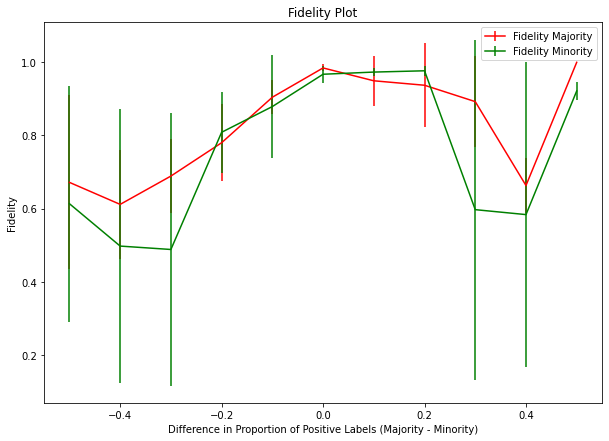

In [23]:
bias_amts = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5]
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_fidel_maj, yerr = y_err_fidel_maj, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, mean_fidel_min, yerr = y_err_fidel_min, label = 'Fidelity Minority', color = "green")
plt.xlabel("Difference in Proportion of Positive Labels (Majority - Minority)")
plt.ylabel("Fidelity")
#plt.xlim(-0.4, 0.5)
#plt.ylim(0.9, 1)
#plt.xlim(1.05, -0.05)
plt.legend()
plt.title("Fidelity Plot")
#plt.savefig('diff_base_rates.jpg')
plt.show()